<h2 align="center">CYFLOD: Cyclic Filtering and Loss Damping for Alleviating Noisy Labels in Fine-grained Visual Classification</h2>
<h3 align="center">Submission: 1008.</h3>
<h3 align="center">Aircraft-Symmetric Noise 20%</h3>

In [1]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from fastai.vision.widgets import ImageClassifierCleaner
from torch.utils.data import Dataset, DataLoader
from efficientnet_pytorch import EfficientNet
from fastai import optimizer, losses, metrics
from functools import partial, wraps
import matplotlib.pyplot as plt
from fastai.vision.all import *
from fastai import __version__
import torchvision
import fastai
import pandas as pd
from pathlib import Path
import seaborn as sns
import random as rn
import torch
import random
import os.path
import math
import shutil
import os

In [2]:
print(fastai.__version__)
print(torch.__version__)
print(torchvision.__version__)

2.6.3
1.11.0
0.12.0


In [3]:
noise_ratio = 0.2
loss_function = 'DampedSCELoss' 
dataset = 'aircrafts'
noise_type = 'sym'
baseline = 'baseline'
scheme = 'scheme'
feat = 'baseline_features'
num_classes  = 100
damp_1 = 0.25
damp_2 = 0.50
best_pth = loss_function+"_"+dataset+"_"+noise_type+"_"+str(noise_ratio)+'_'+str(damp_1)+'_'+baseline
feature_path = loss_function+"_"+dataset+"_"+noise_type+"_"+str(noise_ratio)+'_'+str(damp_1)+'_'+feat
damp_1_features =  loss_function+"_"+dataset+"_"+noise_type+"_"+str(noise_ratio)+'_'+str(damp_1)
damp_1_csvs = loss_function+"_"+dataset+"_"+noise_type+"_"+str(noise_ratio)+'_'+str(damp_1)
damp_2_features =  loss_function+"_"+dataset+"_"+noise_type+"_"+str(noise_ratio)+'_'+str(damp_2)
damp_2_csvs = loss_function+"_"+dataset+"_"+noise_type+"_"+str(noise_ratio)+'_'+str(damp_2)

print(f'Best model: {best_pth}')
print(f'Model Features: {feature_path}')
print(f'Saving features from Scheme delta = 0.25: {damp_1_features}')
print(f'Csv save: {damp_1_csvs}')
print(f'Saving features from Scheme delta = 0.25: {damp_2_features}')
print(f'Saving csv for damp_2: {damp_2_csvs}')

Best model: DampedSCELoss_aircrafts_sym_0.2_0.25_baseline
Model Features: DampedSCELoss_aircrafts_sym_0.2_0.25_baseline_features
Saving features from Scheme delta = 0.25: DampedSCELoss_aircrafts_sym_0.2_0.25
Csv save: DampedSCELoss_aircrafts_sym_0.2_0.25
Saving features from Scheme delta = 0.25: DampedSCELoss_aircrafts_sym_0.2_0.5
Saving csv for damp_2: DampedSCELoss_aircrafts_sym_0.2_0.5


# Declaration of Efficient Net family with Resolution,and Batch size

In [2]:
architecture = 'efficientnet-b4'

effnet_size = ({
    'efficientnet-b0':300,      # original resolution
    'efficientnet-b1':240,      # original resolution
    'efficientnet-b2':260,      # original resolution
    'efficientnet-b3':400,      # original resolution
    'efficientnet-b4':450,      # original resolution
    'efficientnet-b5':456,      # original resolution
    'efficientnet-b6':528,      # original resolution
    'efficientnet-b7':600,      # original resolution
    'efficientnet-lite0':224,
    'efficientnet-lite2':260,
    'efficientnet-lite4':384,
    'resnet18':224,
    'resnet34':224,
    'resnet50':224,
    'resnet101':224,
    'resnet152':224
})
batch_size = ({ 
    'efficientnet-b0':128, # bs = 256 for B1
    'efficientnet-b1':120,      #
    'efficientnet-b2':160,       #88 160
    'efficientnet-b3':16,       #
    'efficientnet-b4':16,       #
    'efficientnet-b5':14,       #
    'efficientnet-b6':16,
    'efficientnet-b7':8,
    'efficientnet-lite0': 160,
    'efficientnet-lite2': 160,
    'efficientnet-lite4':24,
    
    'resnet18':400,             # 3080: ok
    'resnet34':320,            # RTX 3090 rocz!
    'resnet50':256,             # 3080: ok
    'resnet101':96,
    'resnet152':64
})

In [4]:
import pandas as pd
train_df = pd.read_csv("aircrafts_sym_0.2.csv")
train_df

,Filepath,Noisy_labels,Label,Label_numeric
0,aircrafts_original/0/0548719.jpg,59,0,0
1,aircrafts_original/0/1152266.jpg,18,0,0
2,aircrafts_original/0/0894380.jpg,0,0,0
3,aircrafts_original/0/0716386.jpg,22,0,0
4,aircrafts_original/0/0450014.jpg,31,0,0
...,...,...,...,...
6662,aircrafts_original/99/1227260.jpg,99,99,99
6663,aircrafts_original/99/1320583.jpg,99,99,99
6664,aircrafts_original/99/0792373.jpg,99,99,99
6665,aircrafts_original/99/1691701.jpg,99,99,99


In [4]:
print(train_df.Noisy_labels.tolist())

[1, 5, 62, 31, 61, 72, 24, 99, 74, 1, 37, 50, 59, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 74, 25, 37, 41, 94, 96, 99, 62, 76, 42, 77, 90, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 96, 50, 73, 18, 79, 72, 40, 97, 71, 42, 37, 65, 30, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 19, 6, 75, 86, 61, 52, 27, 7, 82, 19, 30, 35, 40, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 29, 16, 79, 20, 80, 5, 81, 18, 79, 35, 86, 57, 71, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,

# Viualization of Training Data, Samples per class

Text(0, 0.5, 'Number of Images')

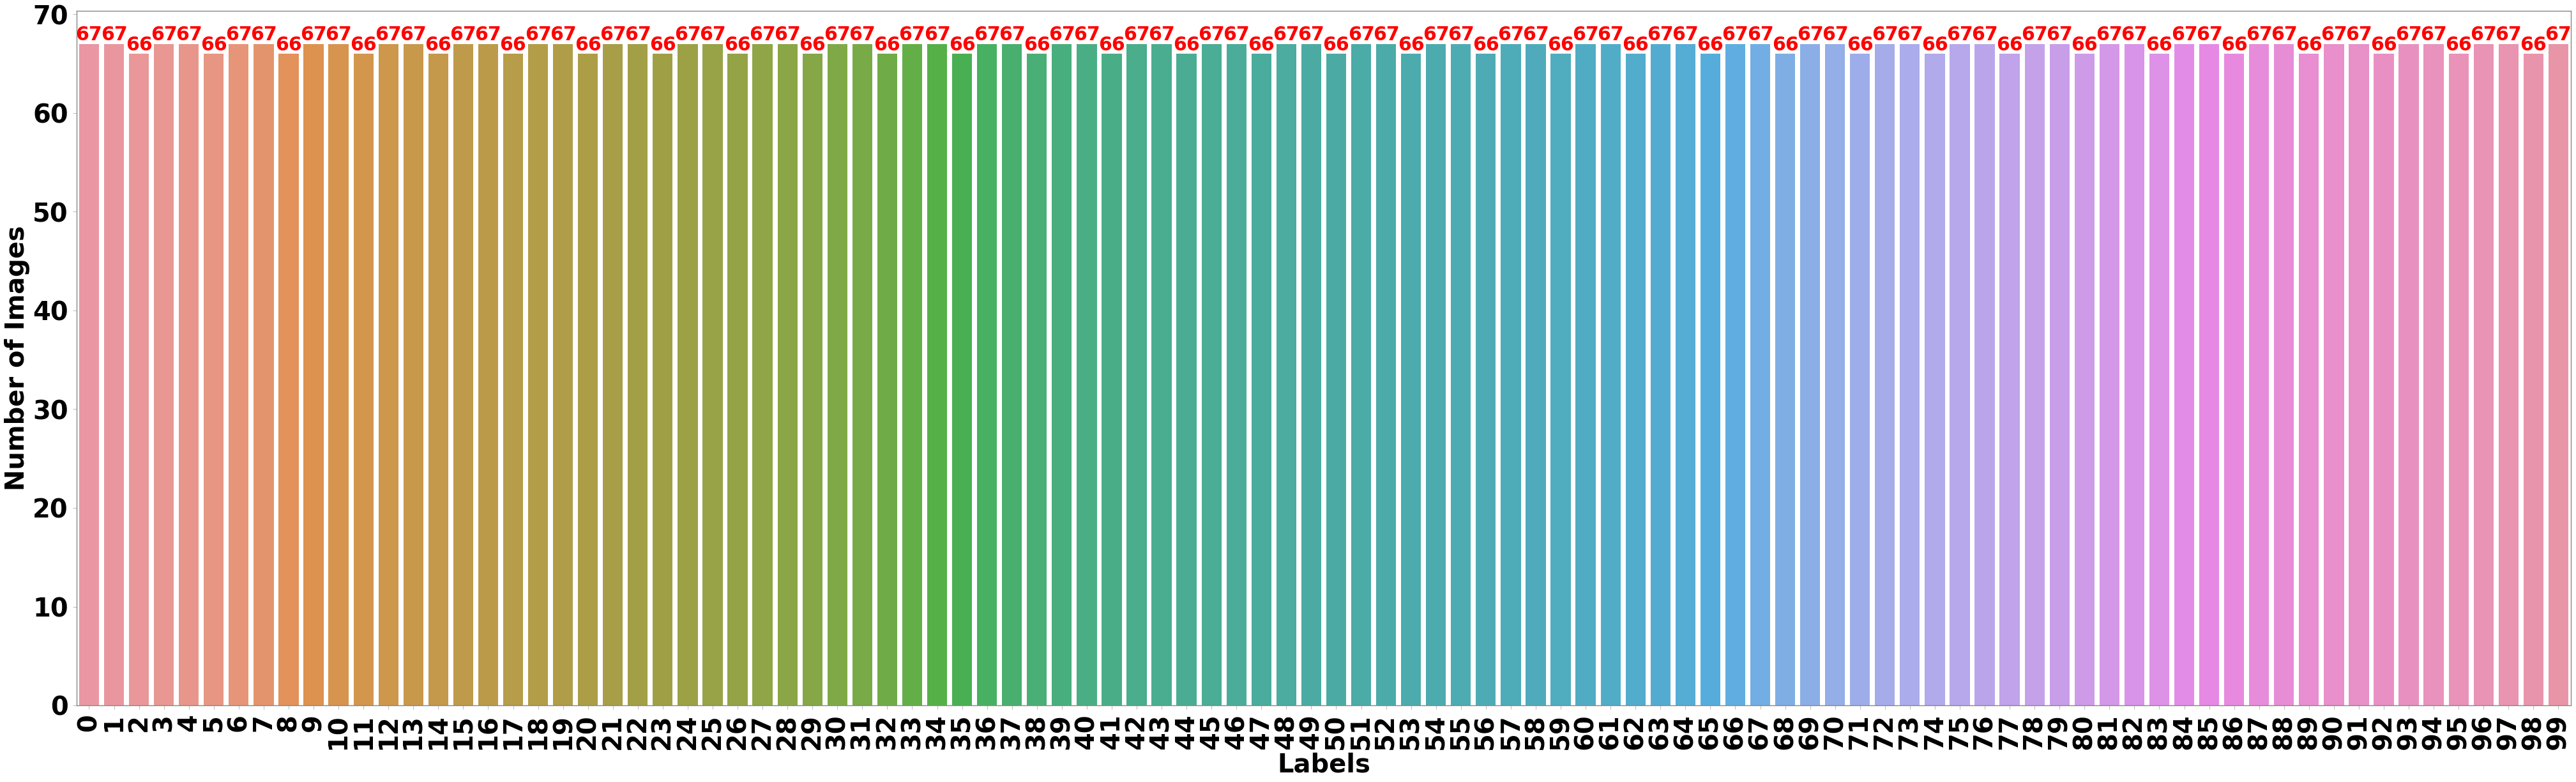

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os.path
plt.rcParams['axes.facecolor'] = 'white'
lbl = train_df['Label']
plt.figure(figsize=(70,20))
ax = sns.countplot(x= lbl, data=train_df)
ax.bar_label(ax.containers[0], weight = 'bold', fontsize = '30', color = 'red')
plt.xticks(rotation=90, fontsize = 40, weight = 'bold', color = 'black')
plt.yticks( fontsize = 40, weight = 'bold', color = 'black')
plt.xlabel("Labels", fontsize = 40, weight = 'bold', color = 'black')
plt.ylabel("Number of Images", fontsize = 40, weight = 'bold', color = 'black')

# Images Per Catergory

In [6]:
number_classes = train_df['Label'].nunique()
print("Number of classes:", number_classes)
counted = train_df.groupby(["Label"]).size()
print(counted)

Number of classes: 100
Label
0     67
1     67
2     66
3     67
4     67
      ..
95    66
96    67
97    67
98    66
99    67
Length: 100, dtype: int64


# Writing testing  Data into CSV  (Test data frame df)

In [7]:
test_dir = "testing"
test_path = Path(test_dir)
filepaths = list(test_path.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')
images = pd.concat([filepaths, labels], axis=1)
test_df = pd.DataFrame(images)
test_df

,Filepath,Label
0,testing/32/1691545.jpg,32
1,testing/32/2212521.jpg,32
2,testing/32/1508910.jpg,32
3,testing/32/1260329.jpg,32
4,testing/32/0199985.jpg,32
...,...,...
3328,testing/42/0773394.jpg,42
3329,testing/42/0875337.jpg,42
3330,testing/42/0759282.jpg,42
3331,testing/42/2228007.jpg,42


Text(0, 0.5, 'Number of Images')

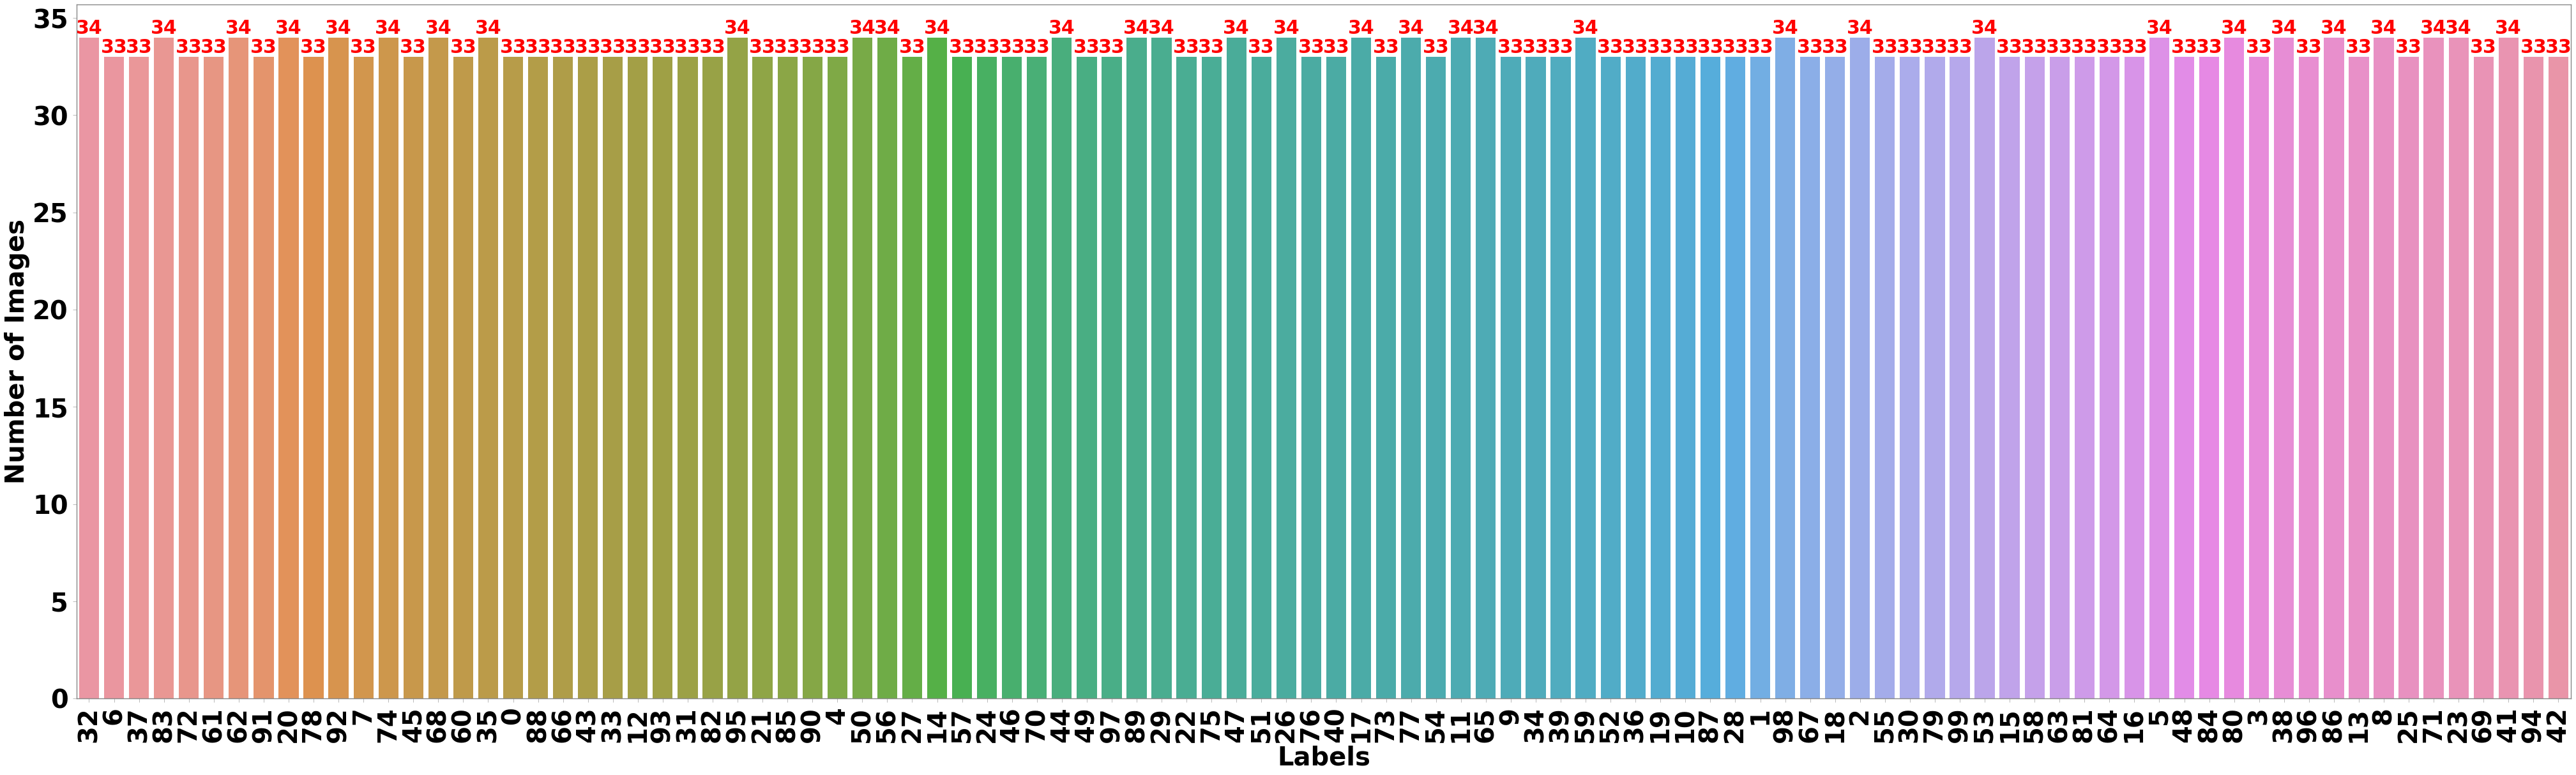

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
lbl = test_df['Label']
# print(lbl)
# print(lbl.size)
plt.figure(figsize=(70,20))
ax = sns.countplot(x= lbl, data=test_df)
ax.bar_label(ax.containers[0], weight = 'bold', fontsize = '30', color = 'red')
plt.xticks(rotation=90, fontsize = 40, weight = 'bold', color = 'black')
plt.yticks( fontsize = 40, weight = 'bold', color = 'black')
plt.xlabel("Labels", fontsize = 40, weight = 'bold', color = 'black')
plt.ylabel("Number of Images", fontsize = 40, weight = 'bold', color = 'black')

# Preparation of data for learner (Fastai learner)

In [12]:
batch_tfms = [Zoom(),Rotate(), Flip(), Brightness(), Contrast(), Saturation()]

In [13]:
bs   = batch_size[architecture]
imgs = effnet_size[architecture]
resize = (imgs*4)//3
data0 = (ImageDataLoaders.from_df(train_df, valid_pct=0.2,bs=bs,label_col=1,
                                        shuffle_train=True,
                                        item_tfms=Resize(imgs),
                                        batch_tfms = batch_tfms))

print("Image size=", imgs)
print("Batch size=", bs)
print("Architecture=", architecture)
print(resize)

Image size= 450
Batch size= 16
Architecture= efficientnet-b4
600


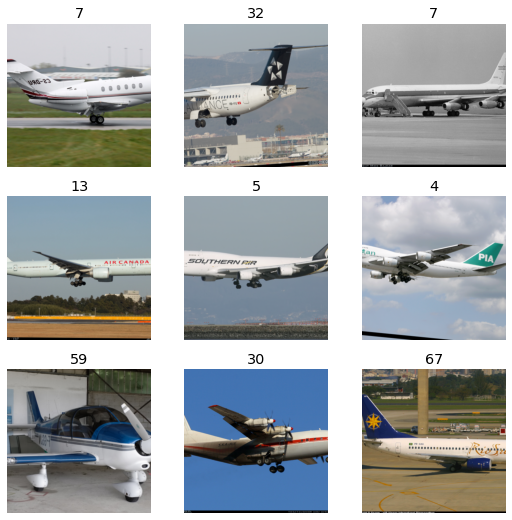

In [14]:
data0.show_batch()

In [15]:
import damped_losses as losses
loss_func = losses.DampedSCELossFlat(num_classes=num_classes, alpha = 0.1, beta = 1.0, delta=0.0,reduction='mean')
model = EfficientNet.from_pretrained(architecture, num_classes=num_classes)
learner_type = Learner

Loaded pretrained weights for efficientnet-b4


In [16]:
best_pth = 'sce_aircrafts_dumpsCls_sym20_b4'
checkpoints = SaveModelCallback(fname=best_pth,monitor='accuracy',comp=np.greater, with_opt=True)
learn = ( learner_type(data0, model,metrics=[accuracy],loss_func=loss_func,
                        cbs=[ShowGraphCallback(),checkpoints]).to_fp16())
print("Best pth is=", best_pth)

Best pth is= sce_aircrafts_dumpsCls_sym20_b4


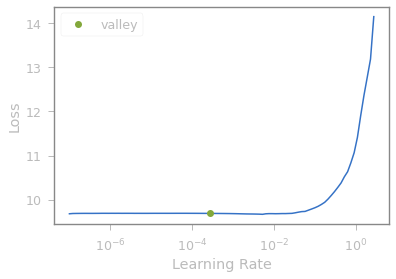

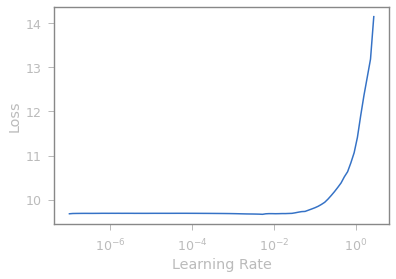

In [17]:
learn.lr_find()
learn.recorder.plot_lr_find()

epoch,train_loss,valid_loss,accuracy,time
0,9.375532,9.282200,0.091523,01:49
1,9.028563,11.516154,0.012753,01:49
2,8.405907,8.927748,0.186047,01:49
3,7.816886,8.062727,0.288072,01:49
4,7.053866,7.063598,0.425356,01:49
5,6.506588,6.542756,0.505626,01:49
6,5.723351,5.961671,0.573143,01:49
7,5.278066,5.587677,0.624906,01:49
8,4.924472,5.393961,0.651913,01:49
9,4.591528,5.357067,0.655664,01:49


Better model found at epoch 0 with accuracy value: 0.09152287989854813.


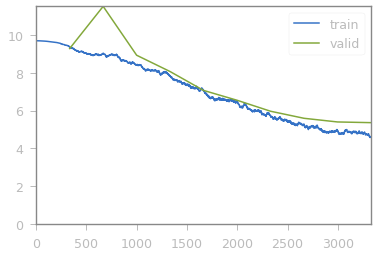

Better model found at epoch 2 with accuracy value: 0.1860465109348297.
Better model found at epoch 3 with accuracy value: 0.28807201981544495.
Better model found at epoch 4 with accuracy value: 0.42535632848739624.
Better model found at epoch 5 with accuracy value: 0.505626380443573.
Better model found at epoch 6 with accuracy value: 0.5731433033943176.
Better model found at epoch 7 with accuracy value: 0.6249062418937683.
Better model found at epoch 8 with accuracy value: 0.6519129872322083.
Better model found at epoch 9 with accuracy value: 0.6556639075279236.


In [18]:
low_lr = 1e-4
lr = 1e-3
learn.fit_one_cycle(10, lr_max = slice(low_lr, lr))

In [19]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy,time
0,4.708607,5.347199,0.652663,01:49
1,4.513960,5.253532,0.668417,01:49
2,4.678726,5.322371,0.661665,01:49
3,4.631178,5.338262,0.655664,01:49
4,4.667796,5.575326,0.628657,01:49
5,4.607828,5.563555,0.621906,01:49
6,4.943140,5.777495,0.609152,01:49
7,4.902938,6.299824,0.549887,01:49
8,5.041827,5.979417,0.585146,01:49
9,5.246586,6.056085,0.580645,01:49


Better model found at epoch 0 with accuracy value: 0.6526631712913513.


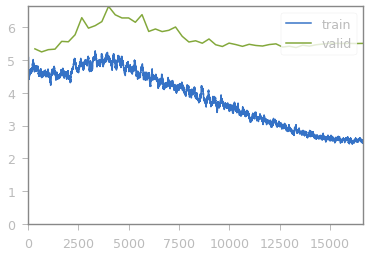

Better model found at epoch 1 with accuracy value: 0.6684170961380005.


In [20]:
learn.fit_one_cycle(50, lr_max = slice(low_lr, lr))

**Loss plot of the baseline:**
    
Due to the high noise in the data, the baseline struggles both in terms of training loss as well as validation loss as the model tends to overfit easily to the noise.

In [21]:
data_test = (ImageDataLoaders.from_df(test_df, valid_pct = 0.0, splitter=None, shuffle=False, label_col=1, item_tfms=Resize(imgs)))
preds = learn.get_preds(dl=data_test)
preds
print("length of preds[1]",len(preds[1]))
acc= accuracy(preds[0], preds[1])
print(" BaselineTop-1 Accuracy:", acc)

length of preds[1] 3333
 BaselineTop-1 Accuracy: TensorBase(0.8152)


 ------------
 B0|Epochs|20|8056   |
 -----------------------------

In [22]:
err = {}
acc = []
log_preds, y  = learn.tta(dl=data_test)
tta_acc = accuracy(log_preds, y)
print(tta_acc)
err[0] = (100.0, 100.0*(1.0-float(tta_acc)))
acc.append(tta_acc)

TensorBase(0.8242)


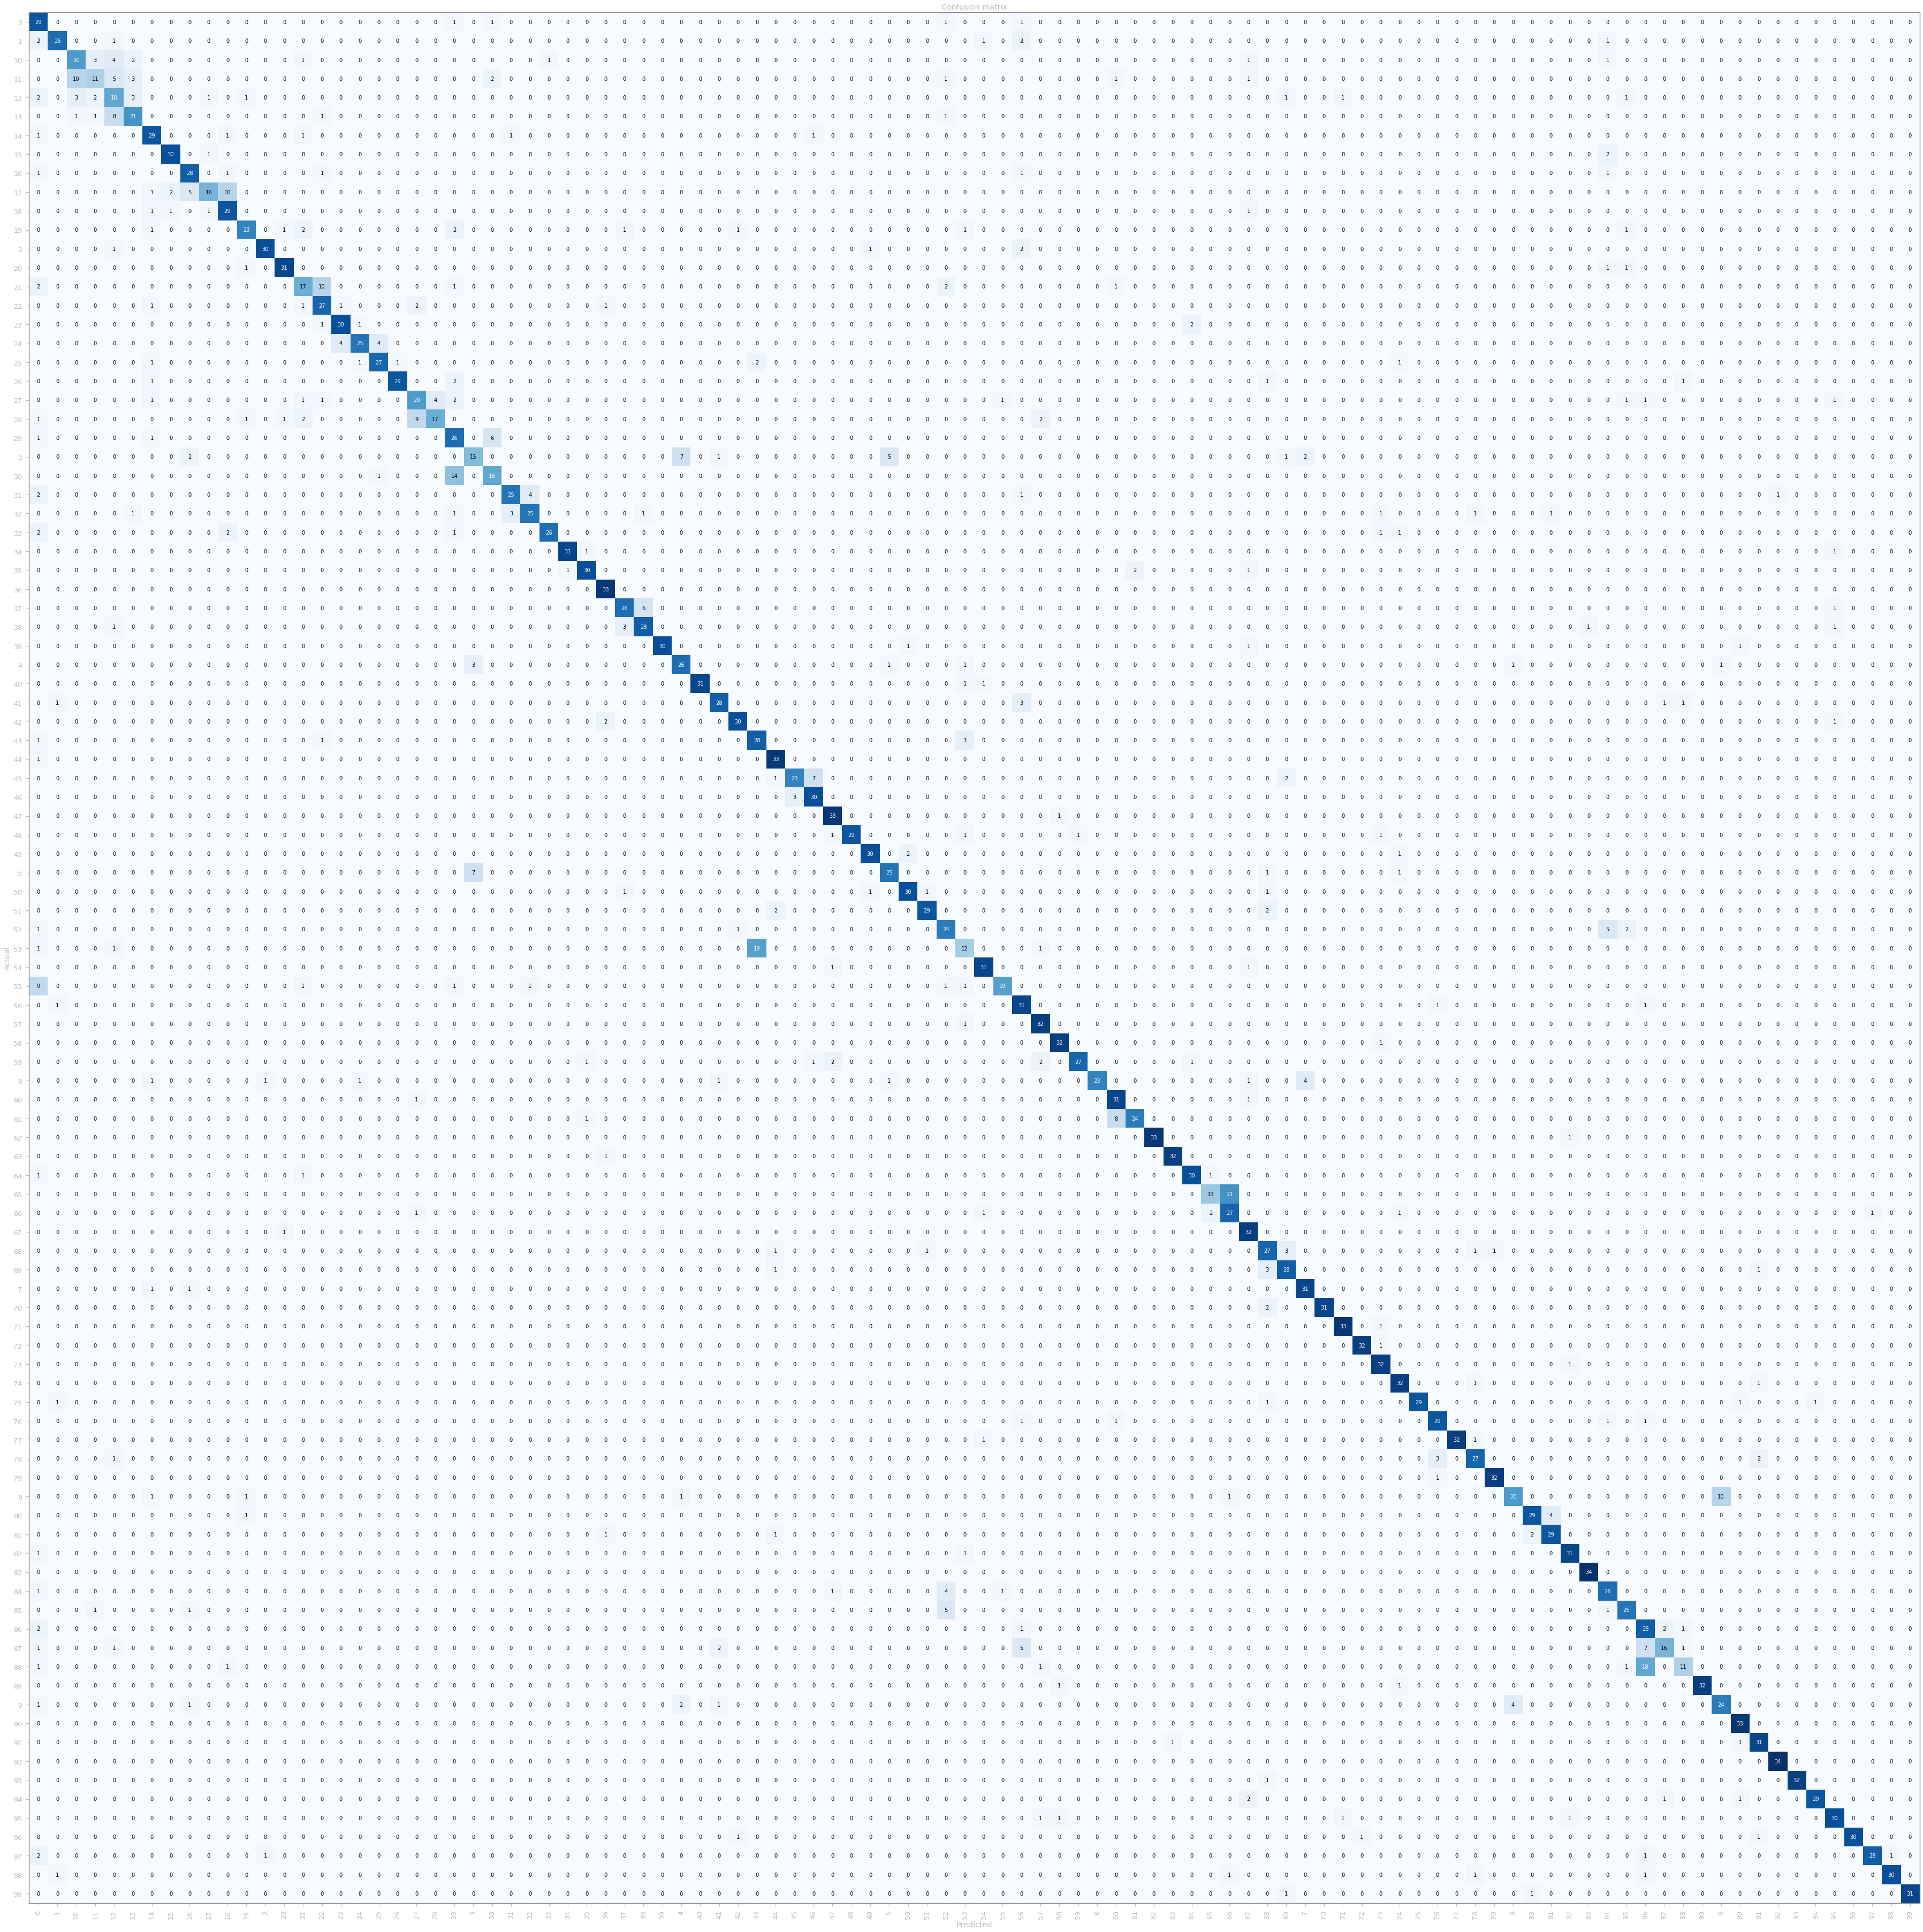

In [23]:
inter_test = ClassificationInterpretation.from_learner(learn, dl =data_test)
inter_test.plot_confusion_matrix(figsize = (50,50))

In [24]:
PATH="models/sce_aircrafts_dumpsCls_sym20_b4.p"
torch.save(model.state_dict(), PATH)

In [25]:
# import shutil
import os
# Specify the path of the folder where you want to create the directory
folder_path = 'models'

# Specify the name of the directory you want to create
directory_name = 'baseline'

# Combine the folder path and directory name
new_directory_path = os.path.join(folder_path, directory_name)

# Create the directory
try:
    # Create the directory
    os.makedirs(new_directory_path)
    print(f"Directory '{directory_name}' created inside '{folder_path}'.")
except FileExistsError:
    print(f"Directory '{directory_name}' already exists inside '{folder_path}'.")

# Now, here we copy the best model for baseline and past into the destination, like the folder we created inside the model directory, named "baseline"!!!!!
source = 'models/'+best_pth+'.pth'

destination = 'models/baseline/'+best_pth+'.pth'
# Copy the file from source to destination
shutil.copy(source, destination)

Directory 'baseline' already exists inside 'models'.


'models/baseline/sce_aircrafts_dumpsCls_sym20_b4.pth'

# CYFLOD Scheme

In [26]:
drop_idxx = []
los = []
top_losses = []
k_samples = 100       # Number of samples for top losses filtering

def class_frequencies(data,class_key='Label'):
    classes = set(data[class_key])
    class_freq = {}
    max_freq = 0.5
    min_freq =100000#1000000
    for cl in classes:
        class_df = data[data[class_key]==cl]
        freq = len(class_df)
        max_freq = max(freq,max_freq)
        min_freq = min(freq,min_freq)
        class_freq[cl] = freq
        #print(f'Frequency of class {cl}: {class_freq[cl]} ')
    print(f'Max frequency is {max_freq}')
    print(f'Min frequency is {min_freq}')
    return class_freq,max_freq,min_freq
    
def russian_roulette(idx, losses, data,class_key='Label', min_prob=0.5,max_prob=0.9): #min_prob=0.5,max_prob=0.9 original values
    
    class_freq,max_freq,min_freq = class_frequencies(data,class_key)
    min_prob = float(min_freq/max_freq)*max_prob
    print(f'Min probability = {min_prob}')
    deltap = (max_prob - min_prob)/(max_freq**2)
    drop_idx = []
    for n,i in enumerate(idx.numpy()):
        l = data.iloc[i][class_key]
        prob = min_prob + (class_freq[l]-min_freq)*deltap
        r = rn.random()
        if  r < prob:
            drop_idx.append(i)
            class_freq[l] -= 1 
    return drop_idx

def data_definition(data,imgs,tfms,model,best_pth,k_samples=100, min_prob=0.4, max_prob = 0.9, largest=True): # k_sample = 1000
    databunch = ( ImageDataLoaders.from_df(data, valid_pct=0.0, bs=bs,label_col=1,
                                        shuffle_train=True,
                                        item_tfms=Resize(imgs),
                                        batch_tfms = batch_tfms))
    learn_cln = (learner_type(databunch, model,metrics=[accuracy],loss_func=loss_func, cbs=[ShowGraphCallback(),checkpoints]).to_fp16())
    learn_cln.load(best_pth)
    entire_training_set_csv0 = (ImageDataLoaders.from_df(data, valid_pct = 0.0, splitter=None, shuffle=False, label_col=1, item_tfms=Resize(imgs)))
    interp = ClassificationInterpretation.from_learner(learn_cln, dl = entire_training_set_csv0)
    losses = None
    idx = None
    if hybrid:
        l_big,idx_big = interp.top_losses(k_samples//2,largest=True)
        l_sm,idx_sm = interp.top_losses(k_samples//2,largest=False)
        losses = torch.cat((l_big,l_sm),0)
        idx = torch.cat((idx_big,idx_sm),0)
    else:
        losses,idx = interp.top_losses(k_samples,largest=largest)
    drop_idx = russian_roulette(idx,losses,data,min_prob = min_prob, max_prob = max_prob)
    data_filtered = data.drop(data.index[drop_idx])
    print(f'Dropped {len(drop_idx)} top losses')
    return data_filtered


delta = 0.05197792270443983
+++++ Training serie: inverse pyramid 0 ++++++++


Max frequency is 67
Min frequency is 66
Min probability = 0.8865671641791044
Dropped 86 top losses
************Round:  0
************data per serie:******************
************length of data per serie:******************
6581


epoch,train_loss,valid_loss,accuracy,time
0,4.684838,4.680806,0.712766,01:50


Better model found at epoch 0 with accuracy value: 0.7127659320831299.


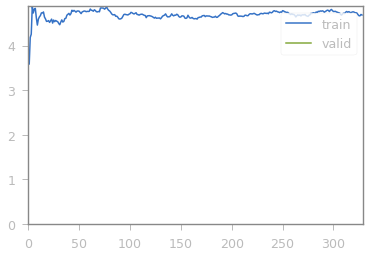

************Round:  0
TTA Accuracy:0.835883617401123
cycle 0 Error Rate is [{0: (1.2899355032248372, 16.411638259887695)}]
delta = 0.10168416076895004
+++++ Training serie: inverse pyramid 1 ++++++++


Max frequency is 67
Min frequency is 54
Min probability = 0.7253731343283583
Dropped 77 top losses
************Round:  1
************data per serie:******************
************length of data per serie:******************
6504


epoch,train_loss,valid_loss,accuracy,time
0,4.793621,4.545563,0.725385,01:46


Better model found at epoch 0 with accuracy value: 0.7253845930099487.


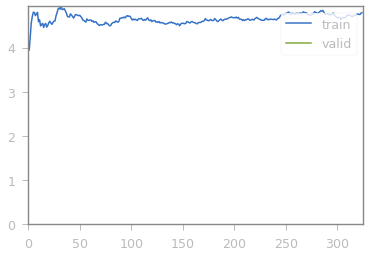

delta = 0.14694631307311828
+++++ Training serie: inverse pyramid 2 ++++++++


Max frequency is 67
Min frequency is 53
Min probability = 0.7119402985074627
Dropped 74 top losses
************Round:  2
************data per serie:******************
************length of data per serie:******************
6430


epoch,train_loss,valid_loss,accuracy,time
0,4.681714,4.296642,0.751166,01:47


Better model found at epoch 0 with accuracy value: 0.7511664032936096.


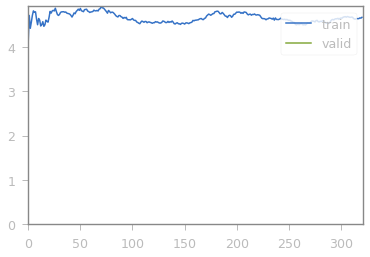

delta = 0.18578620636934853
+++++ Training serie: inverse pyramid 3 ++++++++


Max frequency is 67
Min frequency is 44
Min probability = 0.591044776119403
Dropped 61 top losses
************Round:  3
************data per serie:******************
************length of data per serie:******************
6369


epoch,train_loss,valid_loss,accuracy,time
0,4.687929,4.134461,0.769049,01:46


Better model found at epoch 0 with accuracy value: 0.7690494656562805.


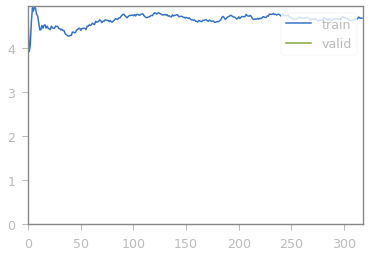

************Round:  3
TTA Accuracy:0.8427842855453491
cycle 0 Error Rate is [{0: (1.2899355032248372, 16.411638259887695), 3: (4.469776511174439, 15.721571445465088)}]
delta = 0.21650635094610965
+++++ Training serie: inverse pyramid 4 ++++++++


Max frequency is 67
Min frequency is 44
Min probability = 0.591044776119403
Dropped 60 top losses
************Round:  4
************data per serie:******************
************length of data per serie:******************
6309


epoch,train_loss,valid_loss,accuracy,time
0,4.464215,4.257053,0.754163,01:45


Better model found at epoch 0 with accuracy value: 0.754163384437561.


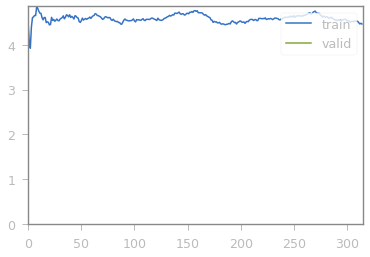

delta = 0.23776412907378838
+++++ Training serie: inverse pyramid 5 ++++++++


Max frequency is 67
Min frequency is 44
Min probability = 0.591044776119403
Dropped 56 top losses
************Round:  5
************data per serie:******************
************length of data per serie:******************
6253


epoch,train_loss,valid_loss,accuracy,time
0,4.476197,4.252050,0.755200,01:43


Better model found at epoch 0 with accuracy value: 0.7552000284194946.


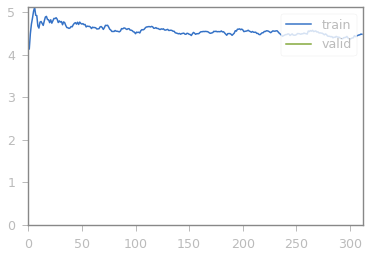

delta = 0.24863047384206832
+++++ Training serie: inverse pyramid 6 ++++++++


Max frequency is 67
Min frequency is 44
Min probability = 0.591044776119403
Dropped 61 top losses
************Round:  6
************data per serie:******************
************length of data per serie:******************
6192


epoch,train_loss,valid_loss,accuracy,time
0,4.270900,4.202949,0.760097,01:41


Better model found at epoch 0 with accuracy value: 0.7600969076156616.


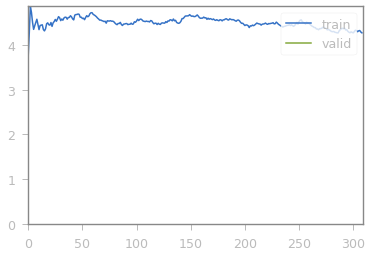

************Round:  6
TTA Accuracy:0.8475847840309143
cycle 0 Error Rate is [{0: (1.2899355032248372, 16.411638259887695), 3: (4.469776511174439, 15.721571445465088), 6: (7.1246437678116115, 15.24152159690857)}]
delta = 0.24863047384206835
+++++ Training serie: inverse pyramid 7 ++++++++


Max frequency is 67
Min frequency is 44
Min probability = 0.591044776119403
Dropped 59 top losses
************Round:  7
************data per serie:******************
************length of data per serie:******************
6133


epoch,train_loss,valid_loss,accuracy,time
0,4.570642,4.254438,0.752039,01:42


Better model found at epoch 0 with accuracy value: 0.7520391345024109.


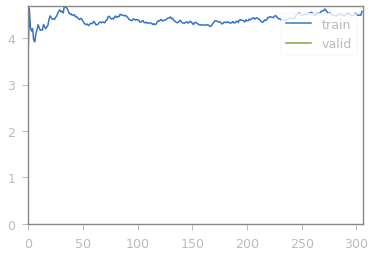

delta = 0.2377641290737884
+++++ Training serie: inverse pyramid 8 ++++++++


Max frequency is 67
Min frequency is 44
Min probability = 0.591044776119403
Dropped 55 top losses
************Round:  8
************data per serie:******************
************length of data per serie:******************
6078


epoch,train_loss,valid_loss,accuracy,time
0,4.291927,4.118528,0.766255,01:42


Better model found at epoch 0 with accuracy value: 0.7662551403045654.


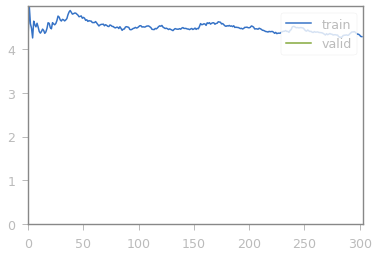

delta = 0.21650635094610968
+++++ Training serie: inverse pyramid 9 ++++++++


Max frequency is 67
Min frequency is 42
Min probability = 0.564179104477612
Dropped 62 top losses
************Round:  9
************data per serie:******************
************length of data per serie:******************
6016


epoch,train_loss,valid_loss,accuracy,time
0,4.357993,4.071555,0.768080,01:39


Better model found at epoch 0 with accuracy value: 0.7680798172950745.


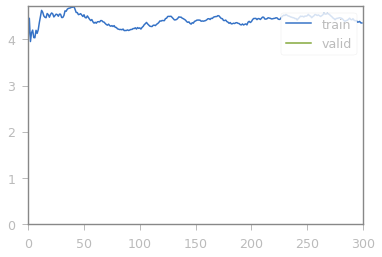

************Round:  9
TTA Accuracy:0.843384325504303
cycle 0 Error Rate is [{0: (1.2899355032248372, 16.411638259887695), 3: (4.469776511174439, 15.721571445465088), 6: (7.1246437678116115, 15.24152159690857), 9: (9.764511774411277, 15.661567449569702)}]
delta = 0.18578620636934862
+++++ Training serie: inverse pyramid 10 ++++++++


Max frequency is 67
Min frequency is 42
Min probability = 0.564179104477612
Dropped 53 top losses
************Round:  10
************data per serie:******************
************length of data per serie:******************
5963


epoch,train_loss,valid_loss,accuracy,time
0,4.293824,4.188181,0.753356,01:40


Better model found at epoch 0 with accuracy value: 0.7533556818962097.


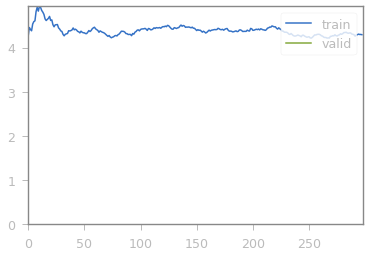

delta = 0.1469463130731183
+++++ Training serie: inverse pyramid 11 ++++++++


Max frequency is 67
Min frequency is 42
Min probability = 0.564179104477612
Dropped 56 top losses
************Round:  11
************data per serie:******************
************length of data per serie:******************
5907


epoch,train_loss,valid_loss,accuracy,time
0,4.550086,4.022552,0.777307,01:37


Better model found at epoch 0 with accuracy value: 0.777307391166687.


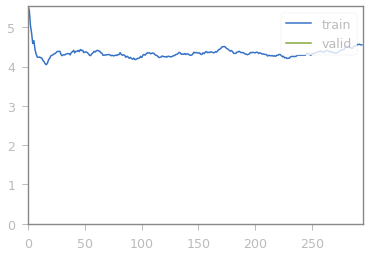

delta = 0.10168416076895001
+++++ Training serie: inverse pyramid 12 ++++++++


Max frequency is 66
Min frequency is 42
Min probability = 0.5727272727272728
Dropped 59 top losses
************Round:  12
************data per serie:******************
************length of data per serie:******************
5848


epoch,train_loss,valid_loss,accuracy,time
0,4.350989,4.134740,0.763045,01:38


Better model found at epoch 0 with accuracy value: 0.7630453109741211.


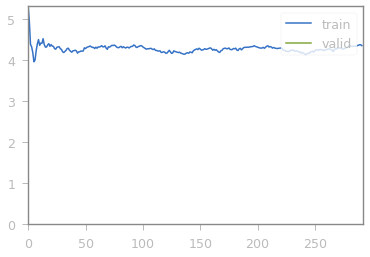

************Round:  12
TTA Accuracy:0.8541854023933411
cycle 0 Error Rate is [{0: (1.2899355032248372, 16.411638259887695), 3: (4.469776511174439, 15.721571445465088), 6: (7.1246437678116115, 15.24152159690857), 9: (9.764511774411277, 15.661567449569702), 12: (12.28438578071096, 14.581459760665894)}]
delta = 0.05197792270443983
+++++ Training serie: inverse pyramid 13 ++++++++


Max frequency is 66
Min frequency is 42
Min probability = 0.5727272727272728
Dropped 56 top losses
************Round:  13
************data per serie:******************
************length of data per serie:******************
5792


epoch,train_loss,valid_loss,accuracy,time
0,4.343752,4.251062,0.749568,01:35


Better model found at epoch 0 with accuracy value: 0.7495682239532471.


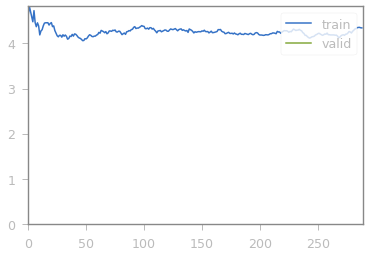

delta = 1.416384724411995e-16
+++++ Training serie: inverse pyramid 14 ++++++++


Max frequency is 66
Min frequency is 42
Min probability = 0.5727272727272728
Dropped 65 top losses
************Round:  14
************data per serie:******************
************length of data per serie:******************
5727


epoch,train_loss,valid_loss,accuracy,time
0,4.347652,4.085594,0.763319,01:34


Better model found at epoch 0 with accuracy value: 0.7633187770843506.


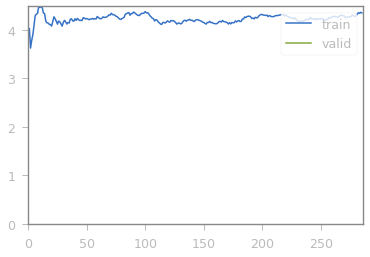

delta = 0.05197792270443983
+++++ Training serie: inverse pyramid 0 ++++++++


Max frequency is 67
Min frequency is 66
Min probability = 0.8865671641791044
Dropped 92 top losses
************Round:  0
************data per serie:******************
************length of data per serie:******************
6575


epoch,train_loss,valid_loss,accuracy,time
0,4.338194,4.076328,0.769582,01:47


Better model found at epoch 0 with accuracy value: 0.7695817351341248.


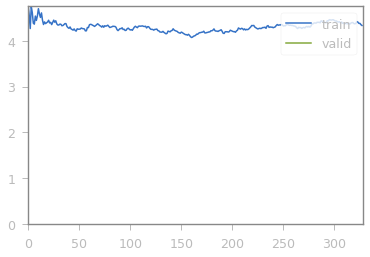

************Round:  0
TTA Accuracy:0.8595859408378601
cycle 1 Error Rate is [{0: (1.2899355032248372, 16.411638259887695), 3: (4.469776511174439, 15.721571445465088), 6: (7.1246437678116115, 15.24152159690857), 9: (9.764511774411277, 15.661567449569702), 12: (12.28438578071096, 14.581459760665894), 15: (1.3799310034498302, 14.04140591621399)}]
delta = 0.10168416076895004
+++++ Training serie: inverse pyramid 1 ++++++++


Max frequency is 67
Min frequency is 54
Min probability = 0.7253731343283583
Dropped 71 top losses
************Round:  1
************data per serie:******************
************length of data per serie:******************
6504


epoch,train_loss,valid_loss,accuracy,time
0,4.294920,4.257323,0.745385,01:47


Better model found at epoch 0 with accuracy value: 0.7453846335411072.


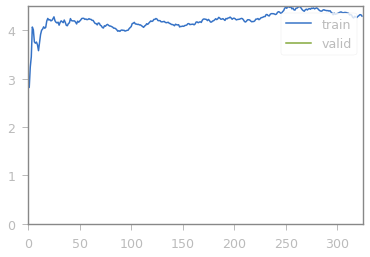

delta = 0.14694631307311828
+++++ Training serie: inverse pyramid 2 ++++++++


Max frequency is 67
Min frequency is 54
Min probability = 0.7253731343283583
Dropped 65 top losses
************Round:  2
************data per serie:******************
************length of data per serie:******************
6439


epoch,train_loss,valid_loss,accuracy,time
0,4.250253,4.145465,0.757576,01:47


Better model found at epoch 0 with accuracy value: 0.7575757503509521.


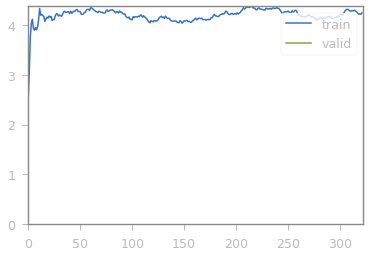

delta = 0.18578620636934853
+++++ Training serie: inverse pyramid 3 ++++++++


Max frequency is 67
Min frequency is 48
Min probability = 0.6447761194029851
Dropped 59 top losses
************Round:  3
************data per serie:******************
************length of data per serie:******************
6380


epoch,train_loss,valid_loss,accuracy,time
0,4.246844,3.975230,0.776646,01:46


Better model found at epoch 0 with accuracy value: 0.7766457796096802.


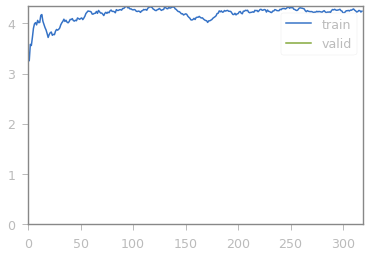

************Round:  3
TTA Accuracy:0.8601860404014587
cycle 1 Error Rate is [{0: (1.2899355032248372, 16.411638259887695), 3: (4.469776511174439, 15.721571445465088), 6: (7.1246437678116115, 15.24152159690857), 9: (9.764511774411277, 15.661567449569702), 12: (12.28438578071096, 14.581459760665894), 15: (1.3799310034498302, 14.04140591621399), 18: (4.30478476076196, 13.981395959854126)}]
delta = 0.21650635094610965
+++++ Training serie: inverse pyramid 4 ++++++++


Max frequency is 67
Min frequency is 48
Min probability = 0.6447761194029851
Dropped 63 top losses
************Round:  4
************data per serie:******************
************length of data per serie:******************
6317


epoch,train_loss,valid_loss,accuracy,time
0,4.291232,3.935367,0.777514,01:43


Better model found at epoch 0 with accuracy value: 0.777513861656189.


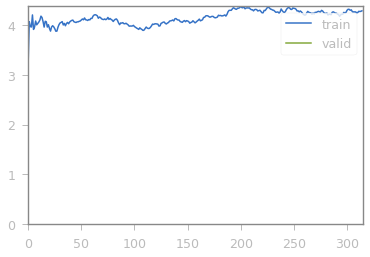

delta = 0.23776412907378838
+++++ Training serie: inverse pyramid 5 ++++++++


Max frequency is 67
Min frequency is 48
Min probability = 0.6447761194029851
Dropped 68 top losses
************Round:  5
************data per serie:******************
************length of data per serie:******************
6249


epoch,train_loss,valid_loss,accuracy,time
0,4.288808,3.810070,0.788631,01:42


Better model found at epoch 0 with accuracy value: 0.7886309027671814.


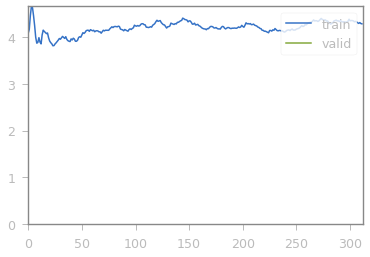

delta = 0.24863047384206832
+++++ Training serie: inverse pyramid 6 ++++++++


Max frequency is 67
Min frequency is 48
Min probability = 0.6447761194029851
Dropped 63 top losses
************Round:  6
************data per serie:******************
************length of data per serie:******************
6186


epoch,train_loss,valid_loss,accuracy,time
0,4.071317,3.908093,0.778496,01:41


Better model found at epoch 0 with accuracy value: 0.7784963846206665.


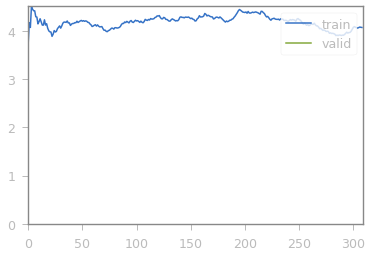

************Round:  6
TTA Accuracy:0.8592859506607056
cycle 1 Error Rate is [{0: (1.2899355032248372, 16.411638259887695), 3: (4.469776511174439, 15.721571445465088), 6: (7.1246437678116115, 15.24152159690857), 9: (9.764511774411277, 15.661567449569702), 12: (12.28438578071096, 14.581459760665894), 15: (1.3799310034498302, 14.04140591621399), 18: (4.30478476076196, 13.981395959854126), 21: (7.214639268036594, 14.071404933929443)}]
delta = 0.24863047384206835
+++++ Training serie: inverse pyramid 7 ++++++++


Max frequency is 67
Min frequency is 48
Min probability = 0.6447761194029851
Dropped 64 top losses
************Round:  7
************data per serie:******************
************length of data per serie:******************
6122


epoch,train_loss,valid_loss,accuracy,time
0,4.214750,3.944670,0.772059,01:40


Better model found at epoch 0 with accuracy value: 0.7720588445663452.


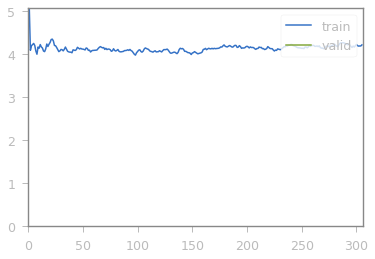

delta = 0.2377641290737884
+++++ Training serie: inverse pyramid 8 ++++++++


Max frequency is 67
Min frequency is 48
Min probability = 0.6447761194029851
Dropped 65 top losses
************Round:  8
************data per serie:******************
************length of data per serie:******************
6057


epoch,train_loss,valid_loss,accuracy,time
0,4.177240,3.939816,0.775392,01:39


Better model found at epoch 0 with accuracy value: 0.7753922343254089.


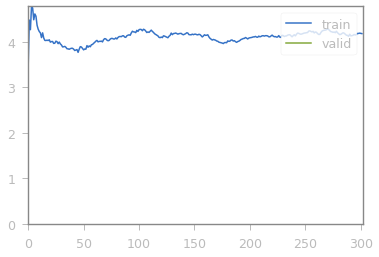

delta = 0.21650635094610968
+++++ Training serie: inverse pyramid 9 ++++++++


Max frequency is 66
Min frequency is 48
Min probability = 0.6545454545454545
Dropped 67 top losses
************Round:  9
************data per serie:******************
************length of data per serie:******************
5990


epoch,train_loss,valid_loss,accuracy,time
0,4.165051,4.014452,0.766277,01:40


Better model found at epoch 0 with accuracy value: 0.7662771344184875.


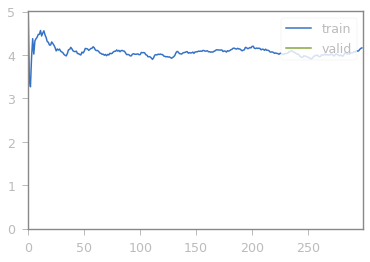

************Round:  9
TTA Accuracy:0.8643864393234253
cycle 1 Error Rate is [{0: (1.2899355032248372, 16.411638259887695), 3: (4.469776511174439, 15.721571445465088), 6: (7.1246437678116115, 15.24152159690857), 9: (9.764511774411277, 15.661567449569702), 12: (12.28438578071096, 14.581459760665894), 15: (1.3799310034498302, 14.04140591621399), 18: (4.30478476076196, 13.981395959854126), 21: (7.214639268036594, 14.071404933929443), 24: (10.154492275386229, 13.56135606765747)}]
delta = 0.18578620636934862
+++++ Training serie: inverse pyramid 10 ++++++++


Max frequency is 66
Min frequency is 48
Min probability = 0.6545454545454545
Dropped 71 top losses
************Round:  10
************data per serie:******************
************length of data per serie:******************
5919


epoch,train_loss,valid_loss,accuracy,time
0,4.179791,3.892676,0.777684,01:37


Better model found at epoch 0 with accuracy value: 0.7776838541030884.


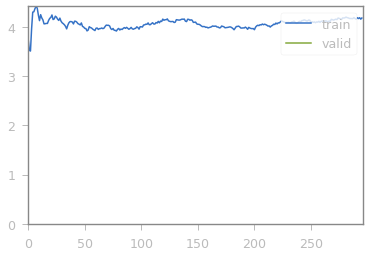

delta = 0.1469463130731183
+++++ Training serie: inverse pyramid 11 ++++++++


Max frequency is 66
Min frequency is 44
Min probability = 0.6
Dropped 68 top losses
************Round:  11
************data per serie:******************
************length of data per serie:******************
5851


epoch,train_loss,valid_loss,accuracy,time
0,4.110651,3.769226,0.791453,01:36


Better model found at epoch 0 with accuracy value: 0.7914530038833618.


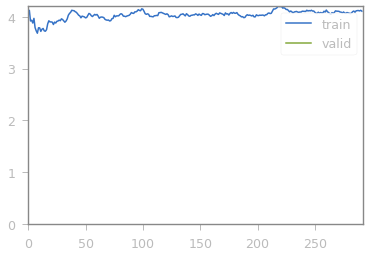

delta = 0.10168416076895001
+++++ Training serie: inverse pyramid 12 ++++++++


Max frequency is 66
Min frequency is 42
Min probability = 0.5727272727272728
Dropped 57 top losses
************Round:  12
************data per serie:******************
************length of data per serie:******************
5794


epoch,train_loss,valid_loss,accuracy,time
0,3.930788,3.930953,0.773748,01:35


Better model found at epoch 0 with accuracy value: 0.7737478613853455.


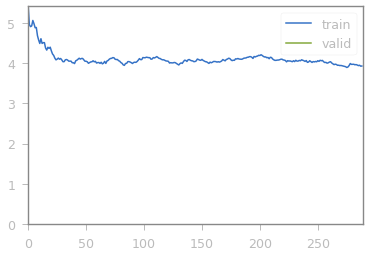

************Round:  12
TTA Accuracy:0.8613861203193665
cycle 1 Error Rate is [{0: (1.2899355032248372, 16.411638259887695), 3: (4.469776511174439, 15.721571445465088), 6: (7.1246437678116115, 15.24152159690857), 9: (9.764511774411277, 15.661567449569702), 12: (12.28438578071096, 14.581459760665894), 15: (1.3799310034498302, 14.04140591621399), 18: (4.30478476076196, 13.981395959854126), 21: (7.214639268036594, 14.071404933929443), 24: (10.154492275386229, 13.56135606765747), 27: (13.094345282735864, 13.861387968063354)}]
delta = 0.05197792270443983
+++++ Training serie: inverse pyramid 13 ++++++++


Max frequency is 65
Min frequency is 39
Min probability = 0.54
Dropped 50 top losses
************Round:  13
************data per serie:******************
************length of data per serie:******************
5744


epoch,train_loss,valid_loss,accuracy,time
0,3.985209,4.089299,0.758711,01:34


Better model found at epoch 0 with accuracy value: 0.7587108016014099.


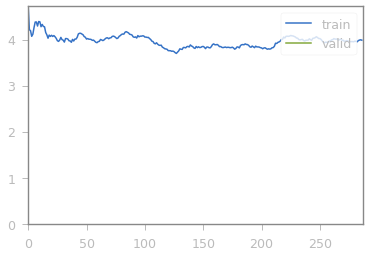

delta = 1.416384724411995e-16
+++++ Training serie: inverse pyramid 14 ++++++++


Max frequency is 64
Min frequency is 39
Min probability = 0.5484375
Dropped 55 top losses
************Round:  14
************data per serie:******************
************length of data per serie:******************
5689


epoch,train_loss,valid_loss,accuracy,time
0,4.079314,3.839398,0.785400,01:33


Better model found at epoch 0 with accuracy value: 0.7854001522064209.


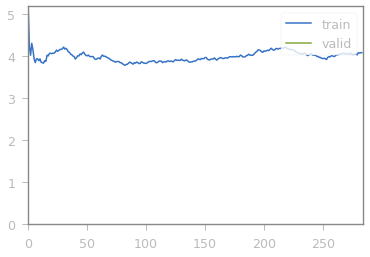

delta = 0.05197792270443983
+++++ Training serie: inverse pyramid 0 ++++++++


Max frequency is 67
Min frequency is 66
Min probability = 0.8865671641791044
Dropped 88 top losses
************Round:  0
************data per serie:******************
************length of data per serie:******************
6579


epoch,train_loss,valid_loss,accuracy,time
0,3.890827,3.922800,0.773384,01:48


Better model found at epoch 0 with accuracy value: 0.7733840346336365.


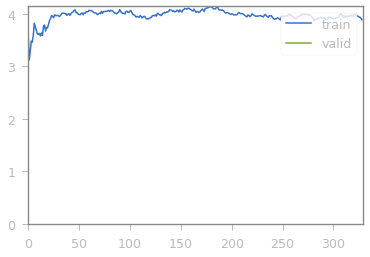

************Round:  0
TTA Accuracy:0.862586259841919
cycle 2 Error Rate is [{0: (1.2899355032248372, 16.411638259887695), 3: (4.469776511174439, 15.721571445465088), 6: (7.1246437678116115, 15.24152159690857), 9: (9.764511774411277, 15.661567449569702), 12: (12.28438578071096, 14.581459760665894), 15: (1.3799310034498302, 14.04140591621399), 18: (4.30478476076196, 13.981395959854126), 21: (7.214639268036594, 14.071404933929443), 24: (10.154492275386229, 13.56135606765747), 27: (13.094345282735864, 13.861387968063354), 30: (1.3199340032998386, 13.741374015808105)}]
delta = 0.10168416076895004
+++++ Training serie: inverse pyramid 1 ++++++++


Max frequency is 67
Min frequency is 53
Min probability = 0.7119402985074627
Dropped 75 top losses
************Round:  1
************data per serie:******************
************length of data per serie:******************
6504


epoch,train_loss,valid_loss,accuracy,time
0,4.024388,3.725615,0.794615,01:46


Better model found at epoch 0 with accuracy value: 0.7946153879165649.


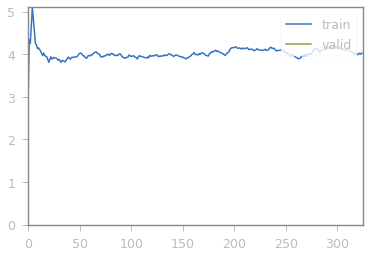

delta = 0.14694631307311828
+++++ Training serie: inverse pyramid 2 ++++++++


Max frequency is 67
Min frequency is 53
Min probability = 0.7119402985074627
Dropped 71 top losses
************Round:  2
************data per serie:******************
************length of data per serie:******************
6433


epoch,train_loss,valid_loss,accuracy,time
0,3.967357,3.835737,0.780715,01:45


Better model found at epoch 0 with accuracy value: 0.7807154059410095.


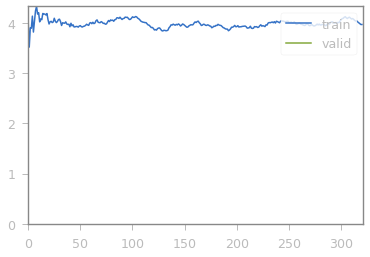

delta = 0.18578620636934853
+++++ Training serie: inverse pyramid 3 ++++++++


Max frequency is 67
Min frequency is 53
Min probability = 0.7119402985074627
Dropped 73 top losses
************Round:  3
************data per serie:******************
************length of data per serie:******************
6360


epoch,train_loss,valid_loss,accuracy,time
0,4.024332,3.704768,0.793239,01:44


Better model found at epoch 0 with accuracy value: 0.7932389974594116.


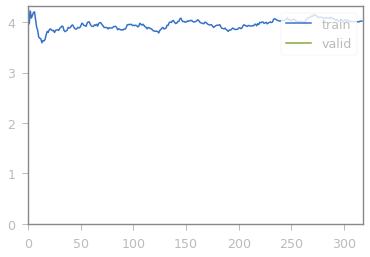

************Round:  3
TTA Accuracy:0.866486668586731
cycle 2 Error Rate is [{0: (1.2899355032248372, 16.411638259887695), 3: (4.469776511174439, 15.721571445465088), 6: (7.1246437678116115, 15.24152159690857), 9: (9.764511774411277, 15.661567449569702), 12: (12.28438578071096, 14.581459760665894), 15: (1.3799310034498302, 14.04140591621399), 18: (4.30478476076196, 13.981395959854126), 21: (7.214639268036594, 14.071404933929443), 24: (10.154492275386229, 13.56135606765747), 27: (13.094345282735864, 13.861387968063354), 30: (1.3199340032998386, 13.741374015808105), 33: (4.604769761511928, 13.351333141326904)}]
delta = 0.21650635094610965
+++++ Training serie: inverse pyramid 4 ++++++++


Max frequency is 67
Min frequency is 49
Min probability = 0.6582089552238806
Dropped 65 top losses
************Round:  4
************data per serie:******************
************length of data per serie:******************
6295


epoch,train_loss,valid_loss,accuracy,time
0,4.102418,3.758054,0.788721,01:43


Better model found at epoch 0 with accuracy value: 0.7887212038040161.


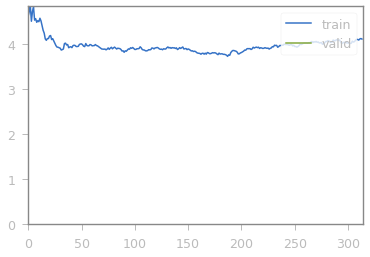

delta = 0.23776412907378838
+++++ Training serie: inverse pyramid 5 ++++++++


Max frequency is 67
Min frequency is 49
Min probability = 0.6582089552238806
Dropped 69 top losses
************Round:  5
************data per serie:******************
************length of data per serie:******************
6226


epoch,train_loss,valid_loss,accuracy,time
0,3.775491,3.685275,0.796787,01:43


Better model found at epoch 0 with accuracy value: 0.7967871427536011.


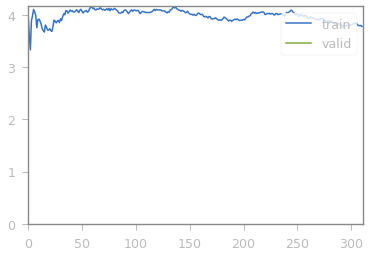

delta = 0.24863047384206832
+++++ Training serie: inverse pyramid 6 ++++++++


Max frequency is 67
Min frequency is 49
Min probability = 0.6582089552238806
Dropped 63 top losses
************Round:  6
************data per serie:******************
************length of data per serie:******************
6163


epoch,train_loss,valid_loss,accuracy,time
0,3.871969,3.702265,0.795455,01:42


Better model found at epoch 0 with accuracy value: 0.7954545617103577.


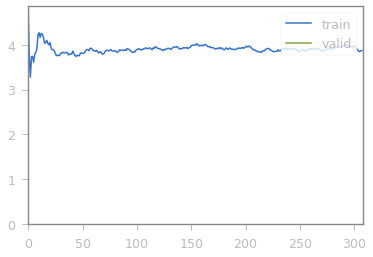

************Round:  6
TTA Accuracy:0.8667866587638855
cycle 2 Error Rate is [{0: (1.2899355032248372, 16.411638259887695), 3: (4.469776511174439, 15.721571445465088), 6: (7.1246437678116115, 15.24152159690857), 9: (9.764511774411277, 15.661567449569702), 12: (12.28438578071096, 14.581459760665894), 15: (1.3799310034498302, 14.04140591621399), 18: (4.30478476076196, 13.981395959854126), 21: (7.214639268036594, 14.071404933929443), 24: (10.154492275386229, 13.56135606765747), 27: (13.094345282735864, 13.861387968063354), 30: (1.3199340032998386, 13.741374015808105), 33: (4.604769761511928, 13.351333141326904), 36: (7.559622018899059, 13.32133412361145)}]
delta = 0.24863047384206835
+++++ Training serie: inverse pyramid 7 ++++++++


Max frequency is 67
Min frequency is 48
Min probability = 0.6447761194029851
Dropped 62 top losses
************Round:  7
************data per serie:******************
************length of data per serie:******************
6101


epoch,train_loss,valid_loss,accuracy,time
0,3.783902,3.802767,0.784426,01:41


Better model found at epoch 0 with accuracy value: 0.784426212310791.


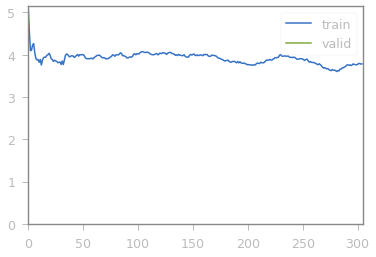

delta = 0.2377641290737884
+++++ Training serie: inverse pyramid 8 ++++++++


Max frequency is 67
Min frequency is 47
Min probability = 0.6313432835820896
Dropped 56 top losses
************Round:  8
************data per serie:******************
************length of data per serie:******************
6045


epoch,train_loss,valid_loss,accuracy,time
0,3.888368,3.695249,0.791563,01:39


Better model found at epoch 0 with accuracy value: 0.7915632724761963.


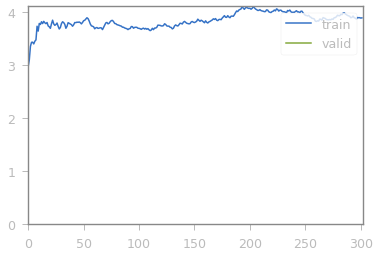

delta = 0.21650635094610968
+++++ Training serie: inverse pyramid 9 ++++++++


Max frequency is 67
Min frequency is 47
Min probability = 0.6313432835820896
Dropped 59 top losses
************Round:  9
************data per serie:******************
************length of data per serie:******************
5986


epoch,train_loss,valid_loss,accuracy,time
0,3.787922,3.894027,0.772765,01:38


Better model found at epoch 0 with accuracy value: 0.7727652192115784.


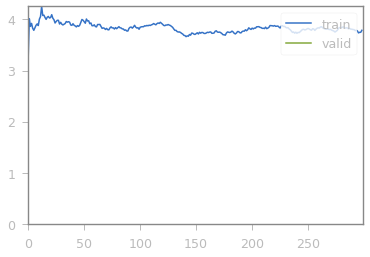

************Round:  9
TTA Accuracy:0.8667866587638855
cycle 2 Error Rate is [{0: (1.2899355032248372, 16.411638259887695), 3: (4.469776511174439, 15.721571445465088), 6: (7.1246437678116115, 15.24152159690857), 9: (9.764511774411277, 15.661567449569702), 12: (12.28438578071096, 14.581459760665894), 15: (1.3799310034498302, 14.04140591621399), 18: (4.30478476076196, 13.981395959854126), 21: (7.214639268036594, 14.071404933929443), 24: (10.154492275386229, 13.56135606765747), 27: (13.094345282735864, 13.861387968063354), 30: (1.3199340032998386, 13.741374015808105), 33: (4.604769761511928, 13.351333141326904), 36: (7.559622018899059, 13.32133412361145), 39: (10.21448927553622, 13.32133412361145)}]
delta = 0.18578620636934862
+++++ Training serie: inverse pyramid 10 ++++++++


Max frequency is 67
Min frequency is 47
Min probability = 0.6313432835820896
Dropped 61 top losses
************Round:  10
************data per serie:******************
************length of data per serie:******************
5925


epoch,train_loss,valid_loss,accuracy,time
0,3.856748,3.811759,0.778903,01:37


Better model found at epoch 0 with accuracy value: 0.7789029479026794.


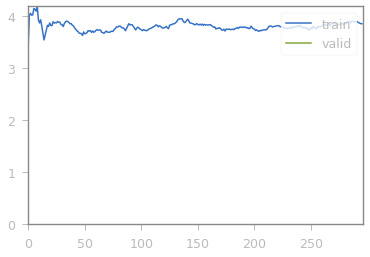

delta = 0.1469463130731183
+++++ Training serie: inverse pyramid 11 ++++++++


Max frequency is 66
Min frequency is 47
Min probability = 0.640909090909091
Dropped 69 top losses
************Round:  11
************data per serie:******************
************length of data per serie:******************
5856


epoch,train_loss,valid_loss,accuracy,time
0,3.921643,3.683526,0.795047,01:36


Better model found at epoch 0 with accuracy value: 0.7950469851493835.


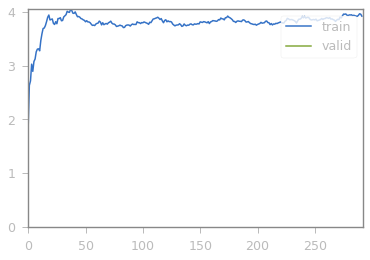

delta = 0.10168416076895001
+++++ Training serie: inverse pyramid 12 ++++++++


Max frequency is 66
Min frequency is 43
Min probability = 0.5863636363636363
Dropped 67 top losses
************Round:  12
************data per serie:******************
************length of data per serie:******************
5789


epoch,train_loss,valid_loss,accuracy,time
0,3.803827,3.652416,0.793431,01:35


Better model found at epoch 0 with accuracy value: 0.793431282043457.


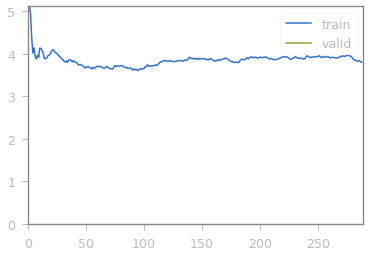

************Round:  12
TTA Accuracy:0.8619862198829651
cycle 2 Error Rate is [{0: (1.2899355032248372, 16.411638259887695), 3: (4.469776511174439, 15.721571445465088), 6: (7.1246437678116115, 15.24152159690857), 9: (9.764511774411277, 15.661567449569702), 12: (12.28438578071096, 14.581459760665894), 15: (1.3799310034498302, 14.04140591621399), 18: (4.30478476076196, 13.981395959854126), 21: (7.214639268036594, 14.071404933929443), 24: (10.154492275386229, 13.56135606765747), 27: (13.094345282735864, 13.861387968063354), 30: (1.3199340032998386, 13.741374015808105), 33: (4.604769761511928, 13.351333141326904), 36: (7.559622018899059, 13.32133412361145), 39: (10.21448927553622, 13.32133412361145), 42: (13.169341532923351, 13.801378011703491)}]
delta = 0.05197792270443983
+++++ Training serie: inverse pyramid 13 ++++++++


Max frequency is 66
Min frequency is 43
Min probability = 0.5863636363636363
Dropped 58 top losses
************Round:  13
************data per serie:******************
************length of data per serie:******************
5731


epoch,train_loss,valid_loss,accuracy,time
0,3.843722,3.670241,0.794066,01:34


Better model found at epoch 0 with accuracy value: 0.794066309928894.


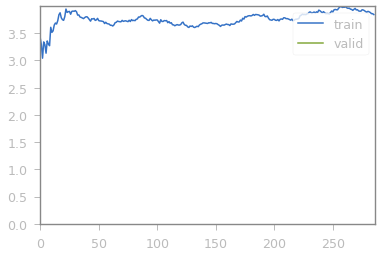

delta = 1.416384724411995e-16
+++++ Training serie: inverse pyramid 14 ++++++++


Max frequency is 66
Min frequency is 43
Min probability = 0.5863636363636363
Dropped 64 top losses
************Round:  14
************data per serie:******************
************length of data per serie:******************
5667


epoch,train_loss,valid_loss,accuracy,time
0,3.700128,3.736634,0.787290,01:33


Better model found at epoch 0 with accuracy value: 0.7872903943061829.


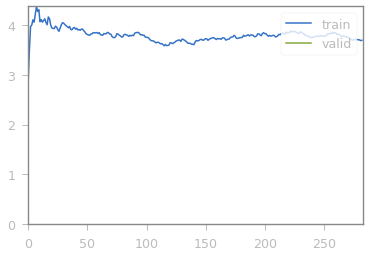

In [27]:
# Define required parameters and lists
n_training_series = 15  # Number of training series for scheme, means iteration in a single cycle
cleaning_cycles = 3   # Number of cleaning cycles for scheme
k_samples = 100       # Number of samples for top losses filtering
delta_max = 0.25       # Max delta value for scheme, damping factor value
min_epochs = 1         # number of loop in a single training of series 
min_lr = 1e-4          # for dynamic learning rates, if use.
kappa_lr = 1           # for dynamic learning rates, if use.
min_prob = 0.5         # probability of min classes.
max_prob = 0.9         # probability of max classes.
delta_epochs_per_serie = 0   # change in number of epochs
data_per_serie = {}
data_per_serie[0] = train_df
largest = True
from_scratch = False
hybrid = False
accs = []
deltas = []
err = {}


for c in range(cleaning_cycles):
    for n in range(n_training_series):
        delta =  delta_max * math.sin( math.pi * float(n+1)/(n_training_series) )
        print(f'delta = {delta}')
        loss_func = losses.DampedSCELossFlat(num_classes=num_classes, alpha = 0.1, beta = 1.0, delta=delta,reduction='mean')
        print(f'+++++ Training serie: inverse pyramid {n} ++++++++')
        epochs_per_serie = min_epochs + n * delta_epochs_per_serie
        lr = min_lr * kappa_lr * (n_training_series - n)
        data_per_serie[n+1] = data_definition(data_per_serie[n],imgs,batch_tfms,model,best_pth,k_samples=k_samples, 
                                              min_prob = min_prob, max_prob=max_prob, largest = largest)
        print("************Round: ",n)
        print("************data per serie:******************")
        print("************length of data per serie:******************")
        print(len(data_per_serie[n+1]))        
        databunch = ( ImageDataLoaders.from_df(data_per_serie[n+1], valid_pct = 0.2,bs=bs,label_col=1,
                                        shuffle_train=True,
                                        item_tfms=Resize(imgs),
                                        batch_tfms = batch_tfms))
        learn =(learner_type(databunch, model,metrics=[accuracy],loss_func=loss_func,
                            cbs=[ShowGraphCallback(),checkpoints]).to_fp16())
        learn.unfreeze() 
        learn.load(best_pth)
        learn.fit_one_cycle(epochs_per_serie, lr_max=slice(1e-6, 5e-5))
        if n%3== 0:
            log_preds, y = learn.tta(dl=data_test)
            print("************Round: ",n)
            tta_acc = accuracy(log_preds, y)
            print(f'TTA Accuracy:{tta_acc}')
            accs.append(tta_acc)
            deltas.append(delta)
            err[c*n_training_series + n] = ( 100.0 *float(1.0 - len(data_per_serie[n+1])/len(data_per_serie[0])) ,  100.0 * (1.0 - float(tta_acc)))
            print(f'cycle {c} Error Rate is [{err}]')
            PATH="models/sce_aircrafts_asym_20_dumpcls25_"+str(c)+"_"+str(n)+".p"
            torch.save(model.state_dict(), PATH)
            csv = data_per_serie[n+1].to_csv("sce_aircrafts_asym_20_dumpcls25_"+str(c)+"_"+str(n)+".csv", index = False)         

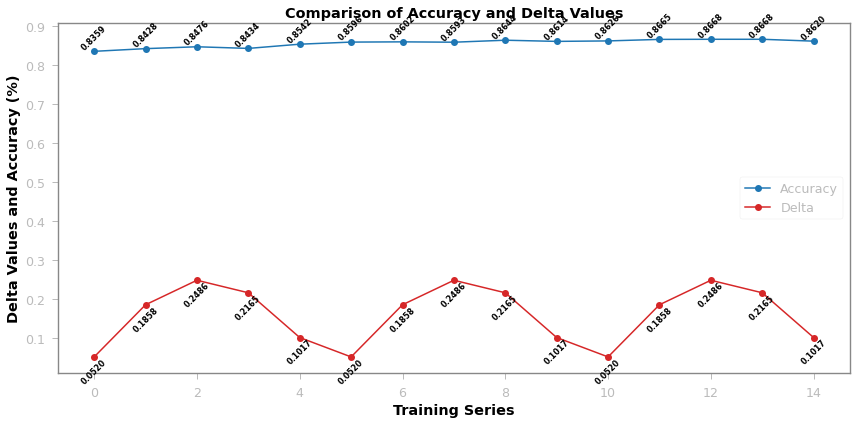

In [29]:

plt.figure(figsize=(12, 6))
plt.plot(accs, label='Accuracy', color='tab:blue', marker='o')
plt.plot(deltas, label='Delta', color='tab:red', marker='o')

# Annotating each point with its value in black and with bold labels
for i, (acc, delta) in enumerate(zip(accs, deltas)):
    plt.text(i, acc, f"{acc:.4f}", ha='center', va='bottom', fontsize=8, rotation=45, color='black', fontweight='bold')
    plt.text(i, delta, f"{delta:.4f}", ha='center', va='top', fontsize=8, rotation=45, color='black', fontweight='bold')

plt.title('Comparison of Accuracy and Delta Values', fontweight='bold', color = 'Black')
plt.xlabel('Training Series', fontweight='bold', color = 'black')
plt.ylabel('Delta Values and Accuracy (%)', fontweight='bold', color = 'Black')
plt.legend()
plt.grid(False)
plt.tight_layout()  # Adjust layout to prevent clipping of annotations
plt.show()


delta = 0.10395584540887966
+++++ Training serie: inverse pyramid 0 ++++++++


Max frequency is 67
Min frequency is 66
Min probability = 0.8865671641791044
Dropped 93 top losses
************Round:  0
************data per serie:******************
************length of data per serie:******************
6574


epoch,train_loss,valid_loss,accuracy,time
0,3.765002,3.567446,0.804414,01:48


Better model found at epoch 0 with accuracy value: 0.8044139742851257.


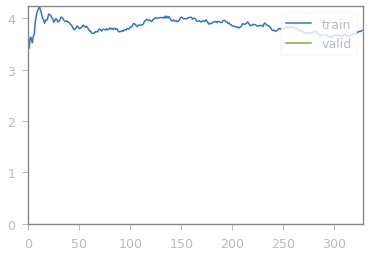

************Round:  0
TTA Accuracy:0.8631862998008728
cycle 0 Error Rate is [{0: (1.3949302534873254, 13.68137001991272)}]
delta = 0.20336832153790008
+++++ Training serie: inverse pyramid 1 ++++++++


Max frequency is 67
Min frequency is 56
Min probability = 0.7522388059701492
Dropped 78 top losses
************Round:  1
************data per serie:******************
************length of data per serie:******************
6496


epoch,train_loss,valid_loss,accuracy,time
0,3.761321,3.599010,0.799076,01:46


Better model found at epoch 0 with accuracy value: 0.7990761995315552.


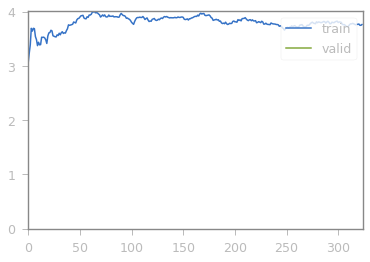

delta = 0.29389262614623657
+++++ Training serie: inverse pyramid 2 ++++++++


Max frequency is 67
Min frequency is 56
Min probability = 0.7522388059701492
Dropped 79 top losses
************Round:  2
************data per serie:******************
************length of data per serie:******************
6417


epoch,train_loss,valid_loss,accuracy,time
0,3.727850,3.461599,0.816836,01:45


Better model found at epoch 0 with accuracy value: 0.8168355226516724.


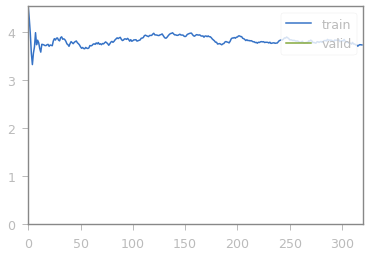

delta = 0.37157241273869707
+++++ Training serie: inverse pyramid 3 ++++++++


Max frequency is 67
Min frequency is 54
Min probability = 0.7253731343283583
Dropped 71 top losses
************Round:  3
************data per serie:******************
************length of data per serie:******************
6346


epoch,train_loss,valid_loss,accuracy,time
0,3.587833,3.908568,0.767533,01:44


Better model found at epoch 0 with accuracy value: 0.7675334811210632.


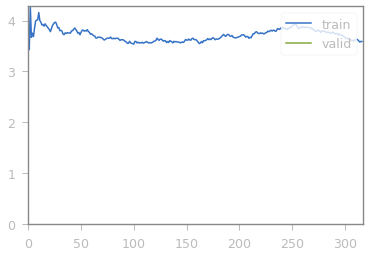

************Round:  3
TTA Accuracy:0.8676867485046387
cycle 0 Error Rate is [{0: (1.3949302534873254, 13.68137001991272), 3: (4.814759262036894, 13.231325149536133)}]
delta = 0.4330127018922193
+++++ Training serie: inverse pyramid 4 ++++++++


Max frequency is 67
Min frequency is 54
Min probability = 0.7253731343283583
Dropped 77 top losses
************Round:  4
************data per serie:******************
************length of data per serie:******************
6269


epoch,train_loss,valid_loss,accuracy,time
0,3.735870,3.452251,0.816441,01:43


Better model found at epoch 0 with accuracy value: 0.8164405226707458.


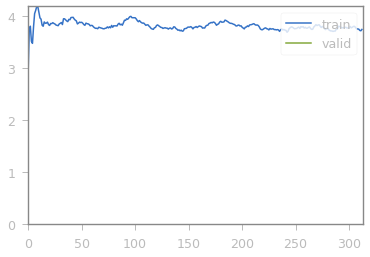

delta = 0.47552825814757677
+++++ Training serie: inverse pyramid 5 ++++++++


Max frequency is 67
Min frequency is 54
Min probability = 0.7253731343283583
Dropped 74 top losses
************Round:  5
************data per serie:******************
************length of data per serie:******************
6195


epoch,train_loss,valid_loss,accuracy,time
0,3.759168,3.627552,0.795803,01:41


Better model found at epoch 0 with accuracy value: 0.7958030700683594.


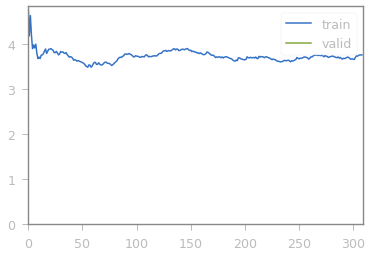

delta = 0.49726094768413664
+++++ Training serie: inverse pyramid 6 ++++++++


Max frequency is 67
Min frequency is 53
Min probability = 0.7119402985074627
Dropped 73 top losses
************Round:  6
************data per serie:******************
************length of data per serie:******************
6122


epoch,train_loss,valid_loss,accuracy,time
0,3.734471,3.649373,0.793301,01:40


Better model found at epoch 0 with accuracy value: 0.7933006286621094.


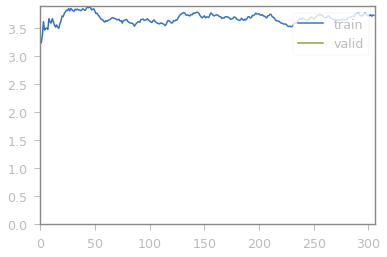

************Round:  6
TTA Accuracy:0.8655865788459778
cycle 0 Error Rate is [{0: (1.3949302534873254, 13.68137001991272), 3: (4.814759262036894, 13.231325149536133), 6: (8.174591270436482, 13.441342115402222)}]
delta = 0.4972609476841367
+++++ Training serie: inverse pyramid 7 ++++++++


Max frequency is 67
Min frequency is 48
Min probability = 0.6447761194029851
Dropped 57 top losses
************Round:  7
************data per serie:******************
************length of data per serie:******************
6065


epoch,train_loss,valid_loss,accuracy,time
0,3.652881,3.646203,0.793075,01:39


Better model found at epoch 0 with accuracy value: 0.7930750250816345.


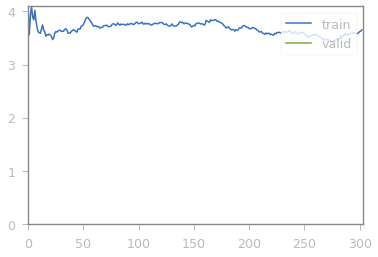

delta = 0.4755282581475768
+++++ Training serie: inverse pyramid 8 ++++++++


Max frequency is 67
Min frequency is 48
Min probability = 0.6447761194029851
Dropped 66 top losses
************Round:  8
************data per serie:******************
************length of data per serie:******************
5999


epoch,train_loss,valid_loss,accuracy,time
0,3.540596,3.611956,0.798999,01:38


Better model found at epoch 0 with accuracy value: 0.7989991903305054.


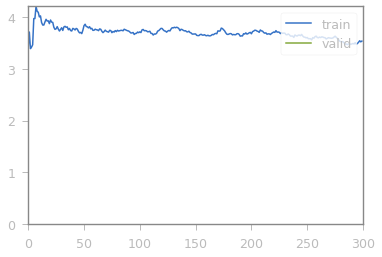

delta = 0.43301270189221935
+++++ Training serie: inverse pyramid 9 ++++++++


Max frequency is 67
Min frequency is 48
Min probability = 0.6447761194029851
Dropped 63 top losses
************Round:  9
************data per serie:******************
************length of data per serie:******************
5936


epoch,train_loss,valid_loss,accuracy,time
0,3.655876,3.458986,0.811289,01:37


Better model found at epoch 0 with accuracy value: 0.8112889528274536.


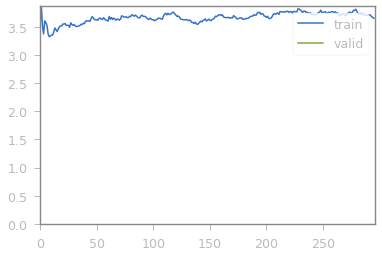

************Round:  9
TTA Accuracy:0.8646864891052246
cycle 0 Error Rate is [{0: (1.3949302534873254, 13.68137001991272), 3: (4.814759262036894, 13.231325149536133), 6: (8.174591270436482, 13.441342115402222), 9: (10.964451777411133, 13.531351089477539)}]
delta = 0.37157241273869723
+++++ Training serie: inverse pyramid 10 ++++++++


Max frequency is 67
Min frequency is 47
Min probability = 0.6313432835820896
Dropped 62 top losses
************Round:  10
************data per serie:******************
************length of data per serie:******************
5874


epoch,train_loss,valid_loss,accuracy,time
0,3.664105,3.477307,0.810903,01:36


Better model found at epoch 0 with accuracy value: 0.8109028935432434.


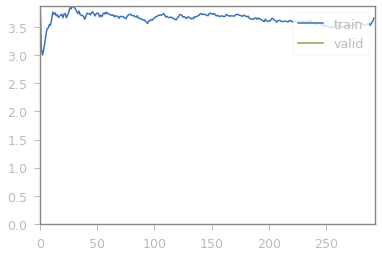

delta = 0.2938926261462366
+++++ Training serie: inverse pyramid 11 ++++++++


Max frequency is 66
Min frequency is 46
Min probability = 0.6272727272727273
Dropped 64 top losses
************Round:  11
************data per serie:******************
************length of data per serie:******************
5810


epoch,train_loss,valid_loss,accuracy,time
0,3.563114,3.542075,0.802065,01:35


Better model found at epoch 0 with accuracy value: 0.8020654320716858.


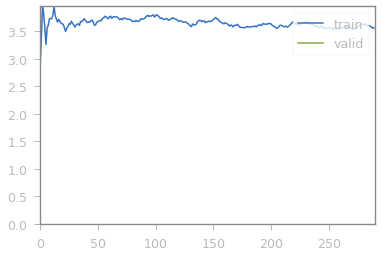

delta = 0.20336832153790002
+++++ Training serie: inverse pyramid 12 ++++++++


Max frequency is 66
Min frequency is 46
Min probability = 0.6272727272727273
Dropped 66 top losses
************Round:  12
************data per serie:******************
************length of data per serie:******************
5744


epoch,train_loss,valid_loss,accuracy,time
0,3.639667,3.517495,0.802265,01:34


Better model found at epoch 0 with accuracy value: 0.8022648096084595.


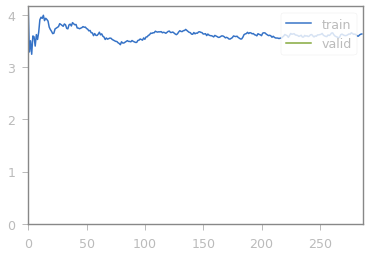

************Round:  12
TTA Accuracy:0.8643864393234253
cycle 0 Error Rate is [{0: (1.3949302534873254, 13.68137001991272), 3: (4.814759262036894, 13.231325149536133), 6: (8.174591270436482, 13.441342115402222), 9: (10.964451777411133, 13.531351089477539), 12: (13.844307784610766, 13.56135606765747)}]
delta = 0.10395584540887966
+++++ Training serie: inverse pyramid 13 ++++++++


Max frequency is 66
Min frequency is 42
Min probability = 0.5727272727272728
Dropped 60 top losses
************Round:  13
************data per serie:******************
************length of data per serie:******************
5684


epoch,train_loss,valid_loss,accuracy,time
0,3.559204,3.501193,0.807218,01:33


Better model found at epoch 0 with accuracy value: 0.8072183132171631.


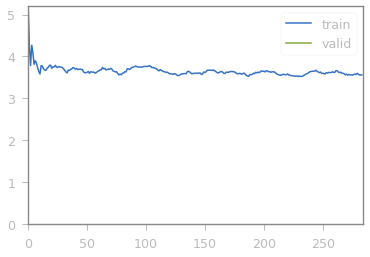

delta = 2.83276944882399e-16
+++++ Training serie: inverse pyramid 14 ++++++++


Max frequency is 66
Min frequency is 36
Min probability = 0.4909090909090909
Dropped 44 top losses
************Round:  14
************data per serie:******************
************length of data per serie:******************
5640


epoch,train_loss,valid_loss,accuracy,time
0,3.622418,3.568791,0.797872,01:32


Better model found at epoch 0 with accuracy value: 0.7978723645210266.


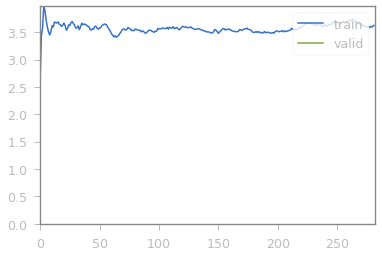

delta = 0.10395584540887966
+++++ Training serie: inverse pyramid 0 ++++++++


Max frequency is 67
Min frequency is 66
Min probability = 0.8865671641791044
Dropped 90 top losses
************Round:  0
************data per serie:******************
************length of data per serie:******************
6577


epoch,train_loss,valid_loss,accuracy,time
0,3.645560,3.465552,0.810646,01:47


Better model found at epoch 0 with accuracy value: 0.8106464147567749.


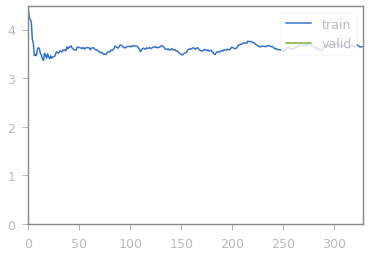

************Round:  0
TTA Accuracy:0.864086389541626
cycle 1 Error Rate is [{0: (1.3949302534873254, 13.68137001991272), 3: (4.814759262036894, 13.231325149536133), 6: (8.174591270436482, 13.441342115402222), 9: (10.964451777411133, 13.531351089477539), 12: (13.844307784610766, 13.56135606765747), 15: (1.3499325033748288, 13.591361045837402)}]
delta = 0.20336832153790008
+++++ Training serie: inverse pyramid 1 ++++++++


Max frequency is 67
Min frequency is 54
Min probability = 0.7253731343283583
Dropped 69 top losses
************Round:  1
************data per serie:******************
************length of data per serie:******************
6508


epoch,train_loss,valid_loss,accuracy,time
0,3.649732,3.591696,0.793236,01:46


Better model found at epoch 0 with accuracy value: 0.7932359576225281.


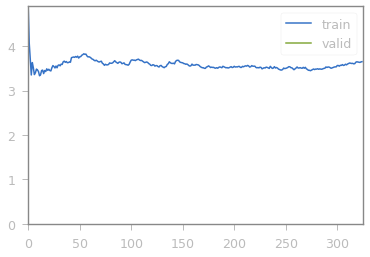

delta = 0.29389262614623657
+++++ Training serie: inverse pyramid 2 ++++++++


Max frequency is 67
Min frequency is 54
Min probability = 0.7253731343283583
Dropped 72 top losses
************Round:  2
************data per serie:******************
************length of data per serie:******************
6436


epoch,train_loss,valid_loss,accuracy,time
0,3.578746,3.449815,0.809635,01:45


Better model found at epoch 0 with accuracy value: 0.809634804725647.


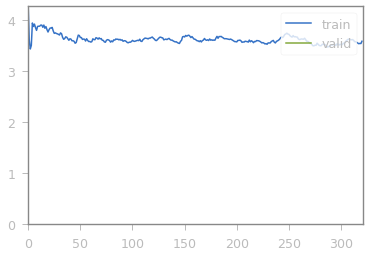

delta = 0.37157241273869707
+++++ Training serie: inverse pyramid 3 ++++++++


Max frequency is 67
Min frequency is 53
Min probability = 0.7119402985074627
Dropped 79 top losses
************Round:  3
************data per serie:******************
************length of data per serie:******************
6357


epoch,train_loss,valid_loss,accuracy,time
0,3.653816,3.368561,0.817467,01:44


Better model found at epoch 0 with accuracy value: 0.8174665570259094.


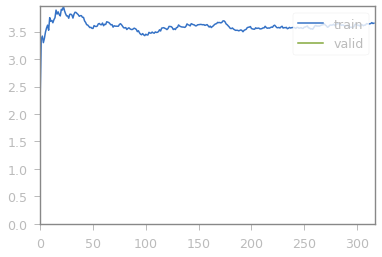

************Round:  3
TTA Accuracy:0.8622862100601196
cycle 1 Error Rate is [{0: (1.3949302534873254, 13.68137001991272), 3: (4.814759262036894, 13.231325149536133), 6: (8.174591270436482, 13.441342115402222), 9: (10.964451777411133, 13.531351089477539), 12: (13.844307784610766, 13.56135606765747), 15: (1.3499325033748288, 13.591361045837402), 18: (4.649767511624415, 13.771378993988037)}]
delta = 0.4330127018922193
+++++ Training serie: inverse pyramid 4 ++++++++


Max frequency is 67
Min frequency is 53
Min probability = 0.7119402985074627
Dropped 66 top losses
************Round:  4
************data per serie:******************
************length of data per serie:******************
6291


epoch,train_loss,valid_loss,accuracy,time
0,3.596098,3.426775,0.811606,01:43


Better model found at epoch 0 with accuracy value: 0.8116057515144348.


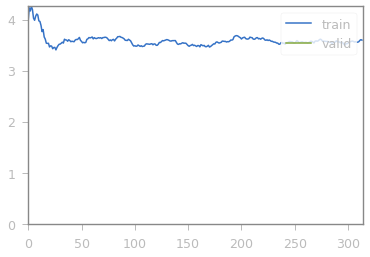

delta = 0.47552825814757677
+++++ Training serie: inverse pyramid 5 ++++++++


Max frequency is 67
Min frequency is 52
Min probability = 0.6985074626865672
Dropped 72 top losses
************Round:  5
************data per serie:******************
************length of data per serie:******************
6219


epoch,train_loss,valid_loss,accuracy,time
0,3.700660,3.232860,0.833467,01:42


Better model found at epoch 0 with accuracy value: 0.833467423915863.


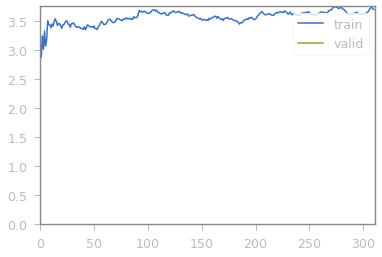

delta = 0.49726094768413664
+++++ Training serie: inverse pyramid 6 ++++++++


Max frequency is 67
Min frequency is 47
Min probability = 0.6313432835820896
Dropped 68 top losses
************Round:  6
************data per serie:******************
************length of data per serie:******************
6151


epoch,train_loss,valid_loss,accuracy,time
0,3.616333,3.428635,0.810569,01:41


Better model found at epoch 0 with accuracy value: 0.8105691075325012.


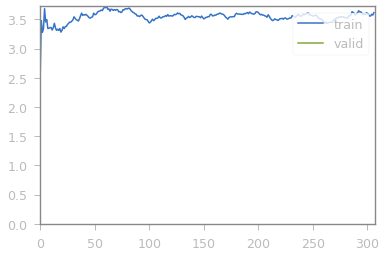

************Round:  6
TTA Accuracy:0.8571857213973999
cycle 1 Error Rate is [{0: (1.3949302534873254, 13.68137001991272), 3: (4.814759262036894, 13.231325149536133), 6: (8.174591270436482, 13.441342115402222), 9: (10.964451777411133, 13.531351089477539), 12: (13.844307784610766, 13.56135606765747), 15: (1.3499325033748288, 13.591361045837402), 18: (4.649767511624415, 13.771378993988037), 21: (7.739613019349035, 14.28142786026001)}]
delta = 0.4972609476841367
+++++ Training serie: inverse pyramid 7 ++++++++


Max frequency is 67
Min frequency is 45
Min probability = 0.6044776119402986
Dropped 57 top losses
************Round:  7
************data per serie:******************
************length of data per serie:******************
6094


epoch,train_loss,valid_loss,accuracy,time
0,3.529508,3.444116,0.807882,01:40


Better model found at epoch 0 with accuracy value: 0.807881772518158.


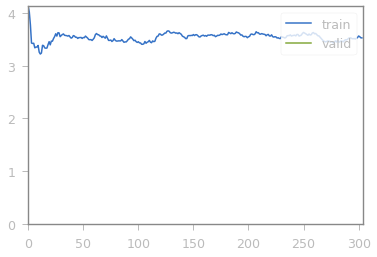

delta = 0.4755282581475768
+++++ Training serie: inverse pyramid 8 ++++++++


Max frequency is 67
Min frequency is 45
Min probability = 0.6044776119402986
Dropped 60 top losses
************Round:  8
************data per serie:******************
************length of data per serie:******************
6034


epoch,train_loss,valid_loss,accuracy,time
0,3.480972,3.524964,0.798507,01:38


Better model found at epoch 0 with accuracy value: 0.7985074520111084.


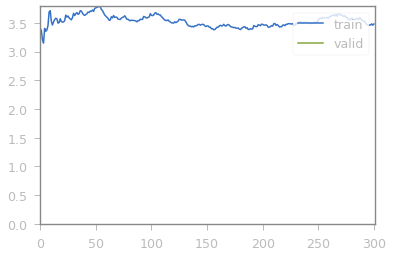

delta = 0.43301270189221935
+++++ Training serie: inverse pyramid 9 ++++++++


Max frequency is 67
Min frequency is 26
Min probability = 0.3492537313432836
Dropped 34 top losses
************Round:  9
************data per serie:******************
************length of data per serie:******************
6000


epoch,train_loss,valid_loss,accuracy,time
0,3.508209,3.412911,0.810000,01:38


Better model found at epoch 0 with accuracy value: 0.8100000023841858.


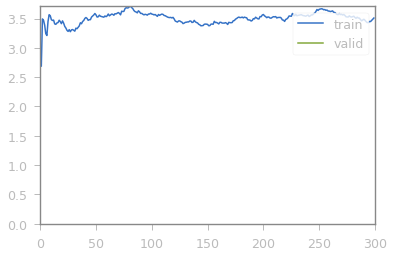

************Round:  9
TTA Accuracy:0.8583858609199524
cycle 1 Error Rate is [{0: (1.3949302534873254, 13.68137001991272), 3: (4.814759262036894, 13.231325149536133), 6: (8.174591270436482, 13.441342115402222), 9: (10.964451777411133, 13.531351089477539), 12: (13.844307784610766, 13.56135606765747), 15: (1.3499325033748288, 13.591361045837402), 18: (4.649767511624415, 13.771378993988037), 21: (7.739613019349035, 14.28142786026001), 24: (10.004499775011244, 14.16141390800476)}]
delta = 0.37157241273869723
+++++ Training serie: inverse pyramid 10 ++++++++


Max frequency is 67
Min frequency is 26
Min probability = 0.3492537313432836
Dropped 34 top losses
************Round:  10
************data per serie:******************
************length of data per serie:******************
5966


epoch,train_loss,valid_loss,accuracy,time
0,3.581772,3.420245,0.811400,01:38


Better model found at epoch 0 with accuracy value: 0.8113998174667358.


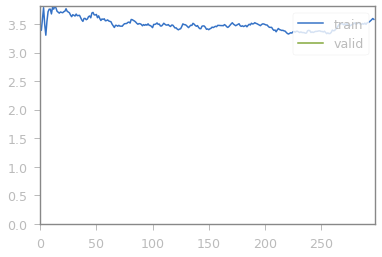

delta = 0.2938926261462366
+++++ Training serie: inverse pyramid 11 ++++++++


Max frequency is 67
Min frequency is 26
Min probability = 0.3492537313432836
Dropped 40 top losses
************Round:  11
************data per serie:******************
************length of data per serie:******************
5926


epoch,train_loss,valid_loss,accuracy,time
0,3.495549,3.491407,0.800844,01:37


Better model found at epoch 0 with accuracy value: 0.8008438944816589.


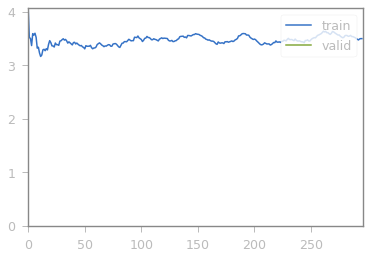

delta = 0.20336832153790002
+++++ Training serie: inverse pyramid 12 ++++++++


Max frequency is 67
Min frequency is 26
Min probability = 0.3492537313432836
Dropped 44 top losses
************Round:  12
************data per serie:******************
************length of data per serie:******************
5882


epoch,train_loss,valid_loss,accuracy,time
0,3.512105,3.459692,0.803571,01:36


Better model found at epoch 0 with accuracy value: 0.8035714030265808.


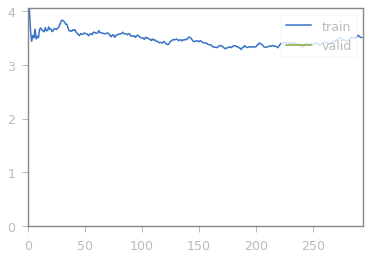

************Round:  12
TTA Accuracy:0.8604860305786133
cycle 1 Error Rate is [{0: (1.3949302534873254, 13.68137001991272), 3: (4.814759262036894, 13.231325149536133), 6: (8.174591270436482, 13.441342115402222), 9: (10.964451777411133, 13.531351089477539), 12: (13.844307784610766, 13.56135606765747), 15: (1.3499325033748288, 13.591361045837402), 18: (4.649767511624415, 13.771378993988037), 21: (7.739613019349035, 14.28142786026001), 24: (10.004499775011244, 14.16141390800476), 27: (11.774411279436025, 13.951396942138672)}]
delta = 0.10395584540887966
+++++ Training serie: inverse pyramid 13 ++++++++


Max frequency is 67
Min frequency is 26
Min probability = 0.3492537313432836
Dropped 31 top losses
************Round:  13
************data per serie:******************
************length of data per serie:******************
5851


epoch,train_loss,valid_loss,accuracy,time
0,3.565525,3.334638,0.818803,01:36


Better model found at epoch 0 with accuracy value: 0.8188034296035767.


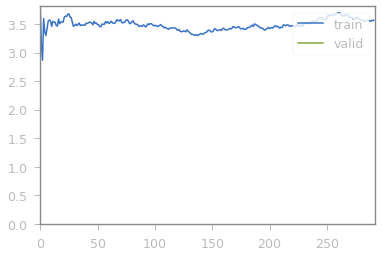

delta = 2.83276944882399e-16
+++++ Training serie: inverse pyramid 14 ++++++++


Max frequency is 67
Min frequency is 26
Min probability = 0.3492537313432836
Dropped 37 top losses
************Round:  14
************data per serie:******************
************length of data per serie:******************
5814


epoch,train_loss,valid_loss,accuracy,time
0,3.376192,3.357457,0.814114,01:35


Better model found at epoch 0 with accuracy value: 0.8141136169433594.


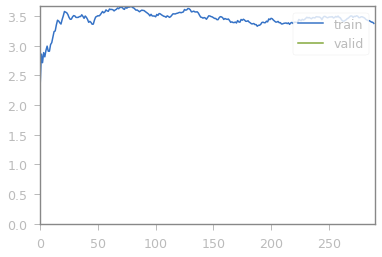

delta = 0.10395584540887966
+++++ Training serie: inverse pyramid 0 ++++++++


Max frequency is 67
Min frequency is 66
Min probability = 0.8865671641791044
Dropped 95 top losses
************Round:  0
************data per serie:******************
************length of data per serie:******************
6572


epoch,train_loss,valid_loss,accuracy,time
0,3.477408,3.419865,0.806697,01:47


Better model found at epoch 0 with accuracy value: 0.8066971302032471.


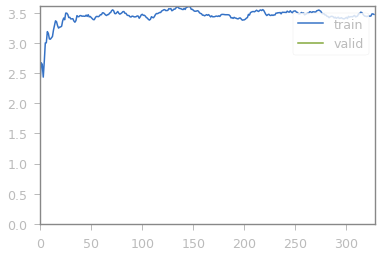

************Round:  0
TTA Accuracy:0.8589859008789062
cycle 2 Error Rate is [{0: (1.3949302534873254, 13.68137001991272), 3: (4.814759262036894, 13.231325149536133), 6: (8.174591270436482, 13.441342115402222), 9: (10.964451777411133, 13.531351089477539), 12: (13.844307784610766, 13.56135606765747), 15: (1.3499325033748288, 13.591361045837402), 18: (4.649767511624415, 13.771378993988037), 21: (7.739613019349035, 14.28142786026001), 24: (10.004499775011244, 14.16141390800476), 27: (11.774411279436025, 13.951396942138672), 30: (1.4249287535623267, 14.101409912109375)}]
delta = 0.20336832153790008
+++++ Training serie: inverse pyramid 1 ++++++++


Max frequency is 67
Min frequency is 52
Min probability = 0.6985074626865672
Dropped 70 top losses
************Round:  1
************data per serie:******************
************length of data per serie:******************
6502


epoch,train_loss,valid_loss,accuracy,time
0,3.641150,3.389310,0.811538,01:46


Better model found at epoch 0 with accuracy value: 0.8115384578704834.


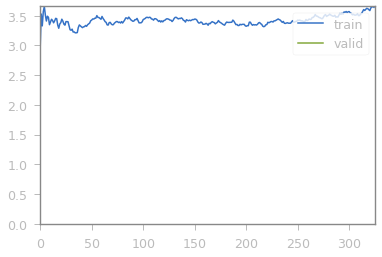

delta = 0.29389262614623657
+++++ Training serie: inverse pyramid 2 ++++++++


Max frequency is 67
Min frequency is 52
Min probability = 0.6985074626865672
Dropped 71 top losses
************Round:  2
************data per serie:******************
************length of data per serie:******************
6431


epoch,train_loss,valid_loss,accuracy,time
0,3.527056,3.308844,0.820373,01:45


Better model found at epoch 0 with accuracy value: 0.8203732371330261.


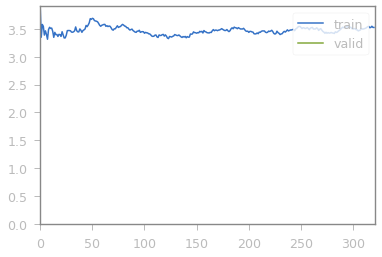

delta = 0.37157241273869707
+++++ Training serie: inverse pyramid 3 ++++++++


Max frequency is 67
Min frequency is 51
Min probability = 0.6850746268656717
Dropped 69 top losses
************Round:  3
************data per serie:******************
************length of data per serie:******************
6362


epoch,train_loss,valid_loss,accuracy,time
0,3.428306,3.391047,0.808176,01:44


Better model found at epoch 0 with accuracy value: 0.8081761002540588.


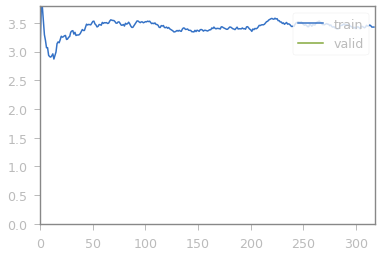

************Round:  3
TTA Accuracy:0.8622862100601196
cycle 2 Error Rate is [{0: (1.3949302534873254, 13.68137001991272), 3: (4.814759262036894, 13.231325149536133), 6: (8.174591270436482, 13.441342115402222), 9: (10.964451777411133, 13.531351089477539), 12: (13.844307784610766, 13.56135606765747), 15: (1.3499325033748288, 13.591361045837402), 18: (4.649767511624415, 13.771378993988037), 21: (7.739613019349035, 14.28142786026001), 24: (10.004499775011244, 14.16141390800476), 27: (11.774411279436025, 13.951396942138672), 30: (1.4249287535623267, 14.101409912109375), 33: (4.574771261436927, 13.771378993988037)}]
delta = 0.4330127018922193
+++++ Training serie: inverse pyramid 4 ++++++++


Max frequency is 67
Min frequency is 51
Min probability = 0.6850746268656717
Dropped 73 top losses
************Round:  4
************data per serie:******************
************length of data per serie:******************
6289


epoch,train_loss,valid_loss,accuracy,time
0,3.427062,3.262353,0.824980,01:43


Better model found at epoch 0 with accuracy value: 0.8249801397323608.


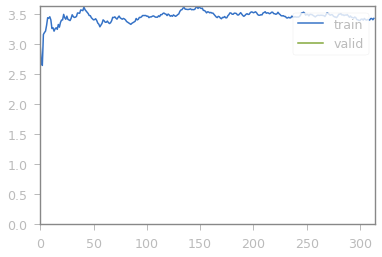

delta = 0.47552825814757677
+++++ Training serie: inverse pyramid 5 ++++++++


Max frequency is 67
Min frequency is 46
Min probability = 0.6179104477611941
Dropped 63 top losses
************Round:  5
************data per serie:******************
************length of data per serie:******************
6226


epoch,train_loss,valid_loss,accuracy,time
0,3.407975,3.427658,0.804819,01:42


Better model found at epoch 0 with accuracy value: 0.8048192858695984.


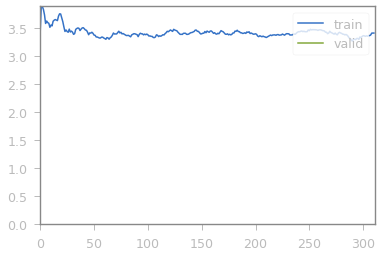

delta = 0.49726094768413664
+++++ Training serie: inverse pyramid 6 ++++++++


Max frequency is 67
Min frequency is 46
Min probability = 0.6179104477611941
Dropped 55 top losses
************Round:  6
************data per serie:******************
************length of data per serie:******************
6171


epoch,train_loss,valid_loss,accuracy,time
0,3.475108,3.190203,0.833063,01:41


Better model found at epoch 0 with accuracy value: 0.8330631852149963.


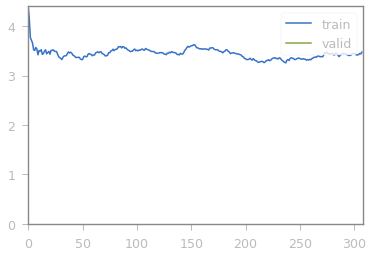

************Round:  6
TTA Accuracy:0.8643864393234253
cycle 2 Error Rate is [{0: (1.3949302534873254, 13.68137001991272), 3: (4.814759262036894, 13.231325149536133), 6: (8.174591270436482, 13.441342115402222), 9: (10.964451777411133, 13.531351089477539), 12: (13.844307784610766, 13.56135606765747), 15: (1.3499325033748288, 13.591361045837402), 18: (4.649767511624415, 13.771378993988037), 21: (7.739613019349035, 14.28142786026001), 24: (10.004499775011244, 14.16141390800476), 27: (11.774411279436025, 13.951396942138672), 30: (1.4249287535623267, 14.101409912109375), 33: (4.574771261436927, 13.771378993988037), 36: (7.439628018599064, 13.56135606765747)}]
delta = 0.4972609476841367
+++++ Training serie: inverse pyramid 7 ++++++++


Max frequency is 67
Min frequency is 46
Min probability = 0.6179104477611941
Dropped 55 top losses
************Round:  7
************data per serie:******************
************length of data per serie:******************
6116


epoch,train_loss,valid_loss,accuracy,time
0,3.413756,3.192130,0.832379,01:40


Better model found at epoch 0 with accuracy value: 0.8323794007301331.


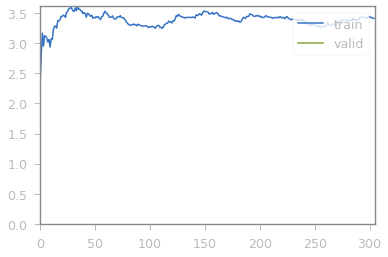

delta = 0.4755282581475768
+++++ Training serie: inverse pyramid 8 ++++++++


Max frequency is 67
Min frequency is 43
Min probability = 0.5776119402985075
Dropped 53 top losses
************Round:  8
************data per serie:******************
************length of data per serie:******************
6063


epoch,train_loss,valid_loss,accuracy,time
0,3.345926,3.266019,0.823432,01:40


Better model found at epoch 0 with accuracy value: 0.8234323263168335.


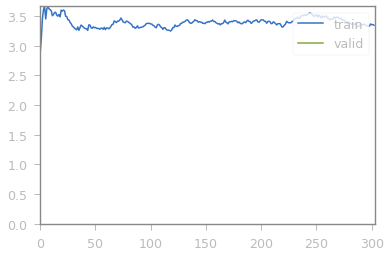

delta = 0.43301270189221935
+++++ Training serie: inverse pyramid 9 ++++++++


Max frequency is 67
Min frequency is 43
Min probability = 0.5776119402985075
Dropped 58 top losses
************Round:  9
************data per serie:******************
************length of data per serie:******************
6005


epoch,train_loss,valid_loss,accuracy,time
0,3.318631,3.251214,0.825978,01:38


Better model found at epoch 0 with accuracy value: 0.8259783387184143.


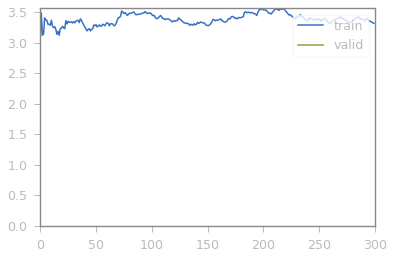

************Round:  9
TTA Accuracy:0.8571857213973999
cycle 2 Error Rate is [{0: (1.3949302534873254, 13.68137001991272), 3: (4.814759262036894, 13.231325149536133), 6: (8.174591270436482, 13.441342115402222), 9: (10.964451777411133, 13.531351089477539), 12: (13.844307784610766, 13.56135606765747), 15: (1.3499325033748288, 13.591361045837402), 18: (4.649767511624415, 13.771378993988037), 21: (7.739613019349035, 14.28142786026001), 24: (10.004499775011244, 14.16141390800476), 27: (11.774411279436025, 13.951396942138672), 30: (1.4249287535623267, 14.101409912109375), 33: (4.574771261436927, 13.771378993988037), 36: (7.439628018599064, 13.56135606765747), 39: (9.929503524823758, 14.28142786026001)}]
delta = 0.37157241273869723
+++++ Training serie: inverse pyramid 10 ++++++++


Max frequency is 67
Min frequency is 43
Min probability = 0.5776119402985075
Dropped 68 top losses
************Round:  10
************data per serie:******************
************length of data per serie:******************
5937


epoch,train_loss,valid_loss,accuracy,time
0,3.331928,3.235450,0.827296,01:37


Better model found at epoch 0 with accuracy value: 0.82729572057724.


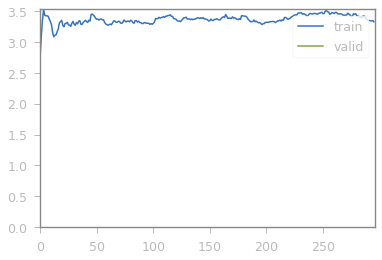

delta = 0.2938926261462366
+++++ Training serie: inverse pyramid 11 ++++++++


Max frequency is 67
Min frequency is 37
Min probability = 0.49701492537313435
Dropped 52 top losses
************Round:  11
************data per serie:******************
************length of data per serie:******************
5885


epoch,train_loss,valid_loss,accuracy,time
0,3.402703,3.186980,0.835174,01:36


Better model found at epoch 0 with accuracy value: 0.8351741433143616.


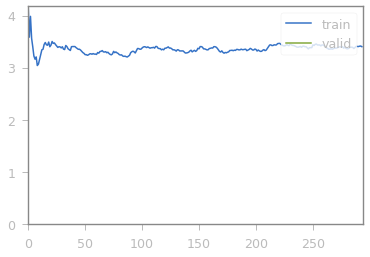

delta = 0.20336832153790002
+++++ Training serie: inverse pyramid 12 ++++++++


Max frequency is 67
Min frequency is 37
Min probability = 0.49701492537313435
Dropped 45 top losses
************Round:  12
************data per serie:******************
************length of data per serie:******************
5840


epoch,train_loss,valid_loss,accuracy,time
0,3.362412,3.189968,0.834760,01:36


Better model found at epoch 0 with accuracy value: 0.8347602486610413.


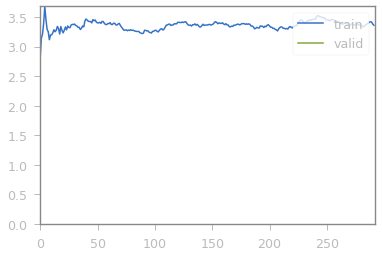

************Round:  12
TTA Accuracy:0.8556855916976929
cycle 2 Error Rate is [{0: (1.3949302534873254, 13.68137001991272), 3: (4.814759262036894, 13.231325149536133), 6: (8.174591270436482, 13.441342115402222), 9: (10.964451777411133, 13.531351089477539), 12: (13.844307784610766, 13.56135606765747), 15: (1.3499325033748288, 13.591361045837402), 18: (4.649767511624415, 13.771378993988037), 21: (7.739613019349035, 14.28142786026001), 24: (10.004499775011244, 14.16141390800476), 27: (11.774411279436025, 13.951396942138672), 30: (1.4249287535623267, 14.101409912109375), 33: (4.574771261436927, 13.771378993988037), 36: (7.439628018599064, 13.56135606765747), 39: (9.929503524823758, 14.28142786026001), 42: (12.404379781010954, 14.431440830230713)}]
delta = 0.10395584540887966
+++++ Training serie: inverse pyramid 13 ++++++++


Max frequency is 67
Min frequency is 37
Min probability = 0.49701492537313435
Dropped 50 top losses
************Round:  13
************data per serie:******************
************length of data per serie:******************
5790


epoch,train_loss,valid_loss,accuracy,time
0,3.133710,3.256937,0.824698,01:35


Better model found at epoch 0 with accuracy value: 0.824697732925415.


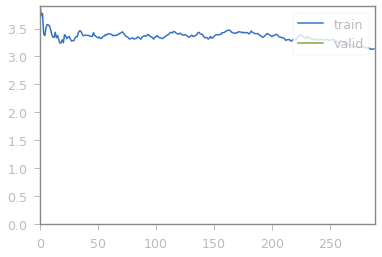

delta = 2.83276944882399e-16
+++++ Training serie: inverse pyramid 14 ++++++++


Max frequency is 67
Min frequency is 37
Min probability = 0.49701492537313435
Dropped 54 top losses
************Round:  14
************data per serie:******************
************length of data per serie:******************
5736


epoch,train_loss,valid_loss,accuracy,time
0,3.399111,3.216483,0.828248,01:34


Better model found at epoch 0 with accuracy value: 0.828247606754303.


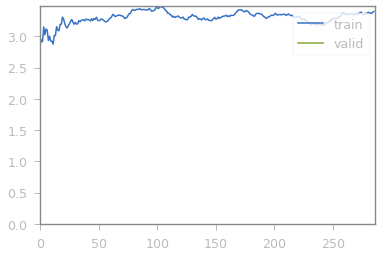

In [31]:
delta_max = 0.50
accs = []
deltas = []
err = {}
for c in range(cleaning_cycles):
    for n in range(n_training_series):
        delta =  delta_max * math.sin( math.pi * float(n+1)/(n_training_series) )
        print(f'delta = {delta}')
        loss_func = losses.DampedSCELossFlat(num_classes=num_classes, alpha = 0.1, beta = 1.0, delta=delta,reduction='mean')        
        print(f'+++++ Training serie: inverse pyramid {n} ++++++++')
        epochs_per_serie = min_epochs + n * delta_epochs_per_serie
        lr = min_lr * kappa_lr * (n_training_series - n)
        data_per_serie[n+1] = data_definition(data_per_serie[n],imgs,batch_tfms,model,best_pth,k_samples=k_samples, 
                                              min_prob = min_prob, max_prob=max_prob, largest = largest)
        print("************Round: ",n)
        print("************data per serie:******************")
        print("************length of data per serie:******************")
        print(len(data_per_serie[n+1]))
        
        databunch = ( ImageDataLoaders.from_df(data_per_serie[n+1], valid_pct = 0.2,bs=bs,label_col=1,
                                        shuffle_train=True,
                                        item_tfms=Resize(imgs),
                                        batch_tfms = batch_tfms))

        learn =(learner_type(databunch, model,metrics=[accuracy],loss_func=loss_func,
                            cbs=[ShowGraphCallback(),checkpoints]).to_fp16())
        learn.unfreeze() 
        learn.load(best_pth)
        learn.fit_one_cycle(epochs_per_serie, lr_max=slice(1e-6, 5e-5))
        if n%3== 0:
            log_preds, y = learn.tta(dl=data_test)
            print("************Round: ",n)
            tta_acc = accuracy(log_preds, y)
            print(f'TTA Accuracy:{tta_acc}')
            accs.append(tta_acc)
            deltas.append(delta)
            err[c*n_training_series + n] = ( 100.0 *float(1.0 - len(data_per_serie[n+1])/len(data_per_serie[0])) ,  100.0 * (1.0 - float(tta_acc)))
            print(f'cycle {c} Error Rate is [{err}]')
#             inter_test = ClassificationInterpretation.from_learner(learn, dl =data_test)
#             inter_test.plot_confusion_matrix(figsize = (10,10))
            PATH="models/sce_aircrafts_asym_20_dumpcls50_"+str(c)+"_"+str(n)+".p"
            torch.save(model.state_dict(), PATH)
            csv = data_per_serie[n+1].to_csv("sce_aircrafts_asym_20_dumpcls50_"+str(c)+"_"+str(n)+".csv", index = False)     
    

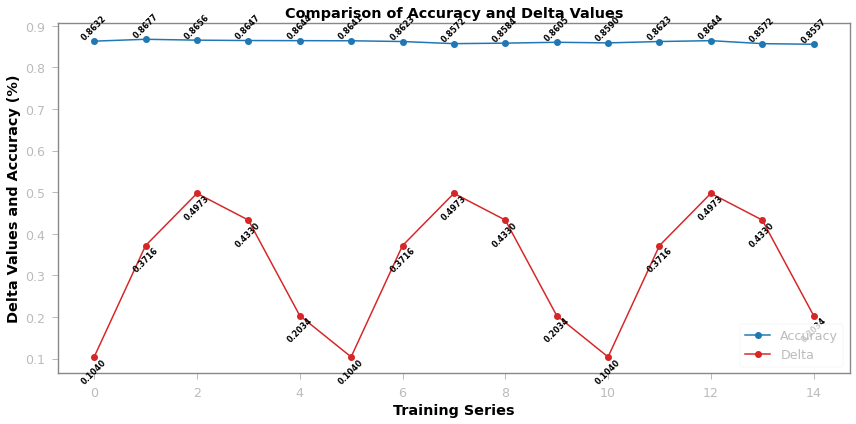

In [33]:
plt.figure(figsize=(12, 6))
plt.plot(accs, label='Accuracy', color='tab:blue', marker='o')
plt.plot(deltas, label='Delta', color='tab:red', marker='o')

# Annotating each point with its value in black and with bold labels
for i, (acc, delta) in enumerate(zip(accs, deltas)):
    plt.text(i, acc, f"{acc:.4f}", ha='center', va='bottom', fontsize=8, rotation=45, color='black', fontweight='bold')
    plt.text(i, delta, f"{delta:.4f}", ha='center', va='top', fontsize=8, rotation=45, color='black', fontweight='bold')

plt.title('Comparison of Accuracy and Delta Values', fontweight='bold', color = 'Black')
plt.xlabel('Training Series', fontweight='bold', color = 'black')
plt.ylabel('Delta Values and Accuracy (%)', fontweight='bold', color = 'Black')
plt.legend()
plt.grid(False)
plt.tight_layout()  # Adjust layout to prevent clipping of annotations
plt.show()
